# Comp 4211 PA 2
## Face Comparison System using Siamese Convolutional Neural Network

### Lee Jae Yeol (20308109)  |  jyleeag@connect.ust.hk

## Outline of the Assignment
### 1. Dataset and Dataloader
### 2. Siamese Convolutional Neural Network
> *  2.1 Convolutional Layers
> *  2.2 Aggregation Function
> *  2.3 Fully Connected Layers
> *  2.4 Siamese Network

### 3. Training and Validation
### 4. Evaluation
### 5. Performance Enhancement
> * 5.1 (A) Optimization 
> * 5.2 (C) Data Augmentation
> * 5.3 (E) Contrastive Loss
### 6. Test Set Prediction


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# zip_path = '/content/drive/MyDrive/Colab Notebooks/pa2/Images.zip'

# # Copy the zip file and move it up one level (AKA out of the drive folder)
# !cp "{zip_path}" .
# os.chdir('/content')
# !unzip -q Images.zip
# #!rm cat_dogs.zip

## Computer Environment
**CPU** - Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz

**Memory** - 8.00GB

**Python Version** - 3.7.9

**Torch Version** - 1.8.0+cu101

In [ ]:
import torch
print(torch.__version__)

1.8.0+cu101


In [ ]:
# check GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi   #only when gpu is set on

Tue Mar 23 18:30:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |   4961MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install torchsummaryX

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummaryX import summary
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

## **4.2.1 Dataset and Dataloader**

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/pa2/'

In [ ]:
a = pd.read_csv(os.path.join(PATH, 'train.csv'))
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id1     4900 non-null   int64
 1   id2     4900 non-null   int64
 2   target  4900 non-null   int64
dtypes: int64(3)
memory usage: 115.0 KB


In [ ]:
b = pd.read_csv(os.path.join(PATH, 'test.csv'))
b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     700 non-null    int64  
 1   id2     700 non-null    int64  
 2   target  0 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 16.5 KB


#### Check for NA / duplicated values within the dataset

In [ ]:
print("Check train.csv NA values")
print(pd.read_csv(os.path.join(PATH, 'train.csv')).isna().sum())
print("\nCheck train.csv duplicate values :", pd.read_csv(os.path.join(PATH, 'train.csv')).duplicated().sum())
print("\nCheck valid.csv NA values")
print(pd.read_csv(os.path.join(PATH, 'valid.csv')).isna().sum())
print("\nCheck valid.csv duplicate values :", pd.read_csv(os.path.join(PATH, 'valid.csv')).duplicated().sum())
print("\nCheck test.csv NA values")
print(pd.read_csv(os.path.join(PATH, 'test.csv')).isna().sum())
print("\nCheck test.csv duplicate values :", pd.read_csv(os.path.join(PATH, 'test.csv')).duplicated().sum())

Check train.csv NA values
id1       0
id2       0
target    0
dtype: int64

Check train.csv duplicate values : 0

Check valid.csv NA values
id1       0
id2       0
target    0
dtype: int64

Check valid.csv duplicate values : 0

Check test.csv NA values
id1         0
id2         0
target    700
dtype: int64

Check test.csv duplicate values : 0


#### Check for oversampling within the dataset

In [ ]:
a = pd.read_csv(os.path.join(PATH, 'train.csv'))
print('label 1 in train dataset:', len(a[a['target'] == 1]))
print('label 0 in train dataset:', len(a[a['target'] == 0]))
b = pd.read_csv(os.path.join(PATH, 'valid.csv'))
print('label 1 in valid dataset:', len(b[b['target'] == 1]))
print('label 0 in valid dataset:', len(b[b['target'] == 0]))

label 1 in train dataset: 2450
label 0 in train dataset: 2450
label 1 in valid dataset: 350
label 0 in valid dataset: 350


In [ ]:
text = pd.read_csv(os.path.join(PATH, 'index.txt'), header = None, delim_whitespace= True, dtype = "string")
text.head()

0
0  1,Data/Images/001/frontal/01.jpg
1  2,Data/Images/001/frontal/02.jpg
2  3,Data/Images/001/frontal/03.jpg
3  4,Data/Images/001/frontal/04.jpg
4  5,Data/Images/001/frontal/05.jpg

### **ImageDataset Class**

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform = None):
        self.df = pd.read_csv(os.path.join(PATH, csv_file))
        self.image_dir = pd.read_csv(os.path.join(PATH, image_dir), header = None, 
                                      delim_whitespace= True, dtype = "string")
        self.transform = transform

# In Python, everything is an object. There are a lot of 'ordinary’system call methods on these objects behind the scene which is not visible to the programmer. Here come what are called as 
# magic methods. Magic methods in python are special methods that are invoked when we run any ordinary python code. To differentiate them with normal functions, they have surrounding double underscores.  
    def __getitem__(self, index):
      
        # getting the index from csv file for index.txt
        id1 = self.df.iloc[index, 0]
        id2 = self.df.iloc[index, 1]
        #print(index)

        if (self.df['target'].isna().sum() != 0):
            label = 0  # initialize with value 0
        else:
            label = self.df.iloc[index, 2].astype(np.float32)

        # use regular expression to properly fit the file directory 
        image1_name = re.search('Image(.+?).jpg', self.image_dir.iloc[id1 -1,0]).group(0)
        image2_name = re.search('Image(.+?).jpg', self.image_dir.iloc[id2 -1,0]).group(0)

        image1 = Image.open(os.path.join(PATH, image1_name)).convert('RGB')
        image2 = Image.open(os.path.join(PATH, image2_name)).convert('RGB')

        if self.transform is not None:
            image1 = self.transform(image1)  
            image2 = self.transform(image2)
      
        return image1, image2, label
    
    # 이거 안하면 TypeError: object of type 'ImageDataset' has no len()
    def __len__(self):
        return len(self.df)

In [ ]:
#The image channel, in the RGB color mode, refers to the individual red, green, and blue parts. In other words, a complete image is composed of three channels of red, green and blue. 
#They work together to produce a complete image. Basically, to describe a pixel, if it is grayscale, then only one value is needed to describe it, which is a single channel.
#If a pixel has three colors of RGB to describe it, it is three channels.

trans = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
# if the image has one channel (grayscale), normalise operation will be transforms.Normalize((0.5, ), (0.5, ))

train_dataset = ImageDataset(csv_file = 'train.csv', image_dir = 'index.txt', transform = trans)
valid_dataset = ImageDataset(csv_file = 'valid.csv', image_dir = 'index.txt', transform = trans)
test_dataset = ImageDataset(csv_file = 'test.csv', image_dir = 'index.txt', transform= trans)

In [ ]:
a,b,c = train_dataset[1]
print(a.size())

torch.Size([1, 32, 32])


### **Dataloader Class**
We lose a lot of features by using a simple for loop to iterate over the data. In particular, we are missing functions like **Batching** the data, **Shuffling** the data and Load the data in parallel using multiprocessing workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using ``collate_fn``. However, default collate should work fine for most use cases.

reference: https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)

## **4.2.2 Siamese Convolutional Neural Network**

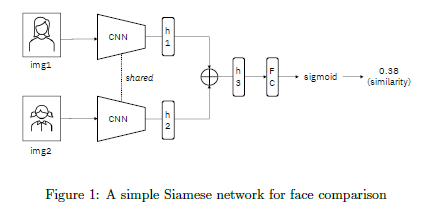 

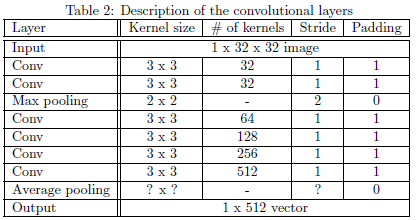

In [ ]:
train_loader

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

output size = [input size - kernel size + padding*2]/stride + 1

* Conv2d(in_channel, out_channel, kernel_size, stride = 1)

* MaxPool2d(kernel_size, stride = None, padding = 0)

input type: torch.Tensor  <br>
input shape: (N x C x H x W)  <br>
        (batch_size, channel, height, width) <br>
Output_channel is the <font color = 'blue'>number of feature maps </font> (activation map), which is often equivalent to the number of kernels that you apply to the input.

You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``

reference: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

#### **Aggregate Function** 
using element-wise absolute difference



####**[Q1]**
The correct kernel size in the average pooling layer is 16. Since the input size for the average pooling layer is [128, 512, 16, 16] and we are expecting an output size of [128, 512, 1, 1], average pooling of kernel 16 will output an 1 x 1 image data. 

In [ ]:
dropout_rate = 0.5

#### **[Q2]**
In deep learning, dropout is equivalent to 'switching off' some arbitrary nodes of the network. It's simple method has proven its efficiency in mitigating overfitting issues and improving generalization errors. 

One method of preventing overfitting the data is to average all the predictions from different neural networks. However, this approach is time-consuming and requires huge computations. Dropping out provides a similar mechanism in the sense that as the nodes are arbitrarily turned off, the same neural network acts as different neural networks. So, through dropout, generalization errors are improved and overfitting issues are also addressed simultaneously.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #input (32 x 32 x 1) -> conv ->  (32 x 32 x 32) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # (32 x 32 x 32) -> conv -> (32 x 32 x 32) -> max_pool -> (16 x 16 x 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)  # maxpool2d layer added
        )
        # (16 x 16 x 32) -> conv -> (16 x 16 x 64)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #(16 x 16 x 64) -> conv -> (16 x 16 x 128)
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #(16 x 16 x 128) -> conv -> (16 x 16 x 256)
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #(16 x 16 x 258) -> conv -> (16 x 16 x 512) -> avg_pool -> (1 x 512)
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 16, stride = None) # avgpool2d layer added
        )
        self.conv = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6)
        self.fc1 = nn.Linear(1 * 512, 512)
        self.drop = nn.Dropout(p = dropout_rate)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def aggregate(self, x1, x2):
        return torch.abs(x1 - x2)

    def forward(self, x1 , x2):
        x1 = self.conv(x1)
        x2 = self.conv(x2)
        out = self.aggregate(x1, x2)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(F.relu(out))
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
        

In [ ]:
model = Net().cuda()
# summary(your_model, input_size=(batch_size, channels, H, W))
summary(model, torch.zeros(128, 1, 32, 32).cuda(), torch.zeros(128, 1, 32, 32).cuda())
#print(list(model.parameters()))


                             Kernel Shape        Output Shape    Params  \
Layer                                                                     
0_conv.0.Conv2d_0           [1, 32, 3, 3]   [128, 32, 32, 32]     320.0   
1_conv.0.Conv2d_0           [1, 32, 3, 3]   [128, 32, 32, 32]         -   
2_conv.0.BatchNorm2d_1               [32]   [128, 32, 32, 32]      64.0   
3_conv.0.BatchNorm2d_1               [32]   [128, 32, 32, 32]         -   
4_conv.0.ReLU_2                         -   [128, 32, 32, 32]         -   
5_conv.0.ReLU_2                         -   [128, 32, 32, 32]         -   
6_conv.1.Conv2d_0          [32, 32, 3, 3]   [128, 32, 32, 32]    9.248k   
7_conv.1.Conv2d_0          [32, 32, 3, 3]   [128, 32, 32, 32]         -   
8_conv.1.BatchNorm2d_1               [32]   [128, 32, 32, 32]      64.0   
9_conv.1.BatchNorm2d_1               [32]   [128, 32, 32, 32]         -   
10_conv.1.ReLU_2                        -   [128, 32, 32, 32]         -   
11_conv.1.ReLU_2         

Kernel Shape       Output Shape    Params  Mult-Adds
Layer                                                                        
0_conv.0.Conv2d_0       [1, 32, 3, 3]  [128, 32, 32, 32]     320.0   294912.0
1_conv.0.Conv2d_0       [1, 32, 3, 3]  [128, 32, 32, 32]       NaN   294912.0
2_conv.0.BatchNorm2d_1           [32]  [128, 32, 32, 32]      64.0       32.0
3_conv.0.BatchNorm2d_1           [32]  [128, 32, 32, 32]       NaN       32.0
4_conv.0.ReLU_2                     -  [128, 32, 32, 32]       NaN        NaN
...                               ...                ...       ...        ...
79_conv.5.AvgPool2d_3               -   [128, 512, 1, 1]       NaN        NaN
80_fc1                     [512, 512]         [128, 512]  262656.0   262144.0
81_drop                             -         [128, 512]       NaN        NaN
82_fc2                       [512, 1]           [128, 1]     513.0      512.0
83_sigmoid                          -           [128, 1]       NaN        NaN

[84 rows x 4 columns]

#### **Helper function to count the total number of trainable parameters (i.e. if requires_grad = True)**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

1842465

#### **[Q3]** 
The total number of trainable parameters in the Siamese network model above is equal to 1842465.

#### **Aggregate Function** 
using concatenation


In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        #input (32 x 32 x 1) -> conv ->  (32 x 32 x 32) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # (32 x 32 x 32) -> conv -> (32 x 32 x 32) -> max_pool -> (16 x 16 x 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)  # maxpool2d layer added
        )
        # (16 x 16 x 32) -> conv -> (16 x 16 x 64)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #(16 x 16 x 64) -> conv -> (16 x 16 x 128)
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #(16 x 16 x 128) -> conv -> (16 x 16 x 256)
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #(16 x 16 x 258) -> conv -> (16 x 16 x 512) -> avg_pool -> (1 x 512)
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 16, stride = None) # avgpool2d layer added
        )
        self.conv = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6)
        self.fc1 = nn.Linear(1024, 512)  # due to concatenation, the input size has doubled
        self.drop = nn.Dropout(p = dropout_rate)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def concat_aggregate(self, x1, x2):
        return torch.cat((x1, x2), 1)  # concat dim = 0 이면 batch size 128 * 2 = 256 됨
                                    # concat dim = 1 이어야 512 * 2 = 1024 그렇게 fc1 input size 1024

    def forward(self, x1 , x2):
        x1 = self.conv(x1)
        x2 = self.conv(x2)
        out = self.concat_aggregate(x1, x2)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(F.relu(out))
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
       

In [ ]:
model2 = Net2().cuda()
# summary(your_model, input_size=(batch_size, channels, H, W))
summary(model2, torch.zeros(128, 1, 32, 32).cuda(), torch.zeros(128, 1, 32, 32).cuda())

                             Kernel Shape        Output Shape    Params  \
Layer                                                                     
0_conv.0.Conv2d_0           [1, 32, 3, 3]   [128, 32, 32, 32]     320.0   
1_conv.0.Conv2d_0           [1, 32, 3, 3]   [128, 32, 32, 32]         -   
2_conv.0.BatchNorm2d_1               [32]   [128, 32, 32, 32]      64.0   
3_conv.0.BatchNorm2d_1               [32]   [128, 32, 32, 32]         -   
4_conv.0.ReLU_2                         -   [128, 32, 32, 32]         -   
5_conv.0.ReLU_2                         -   [128, 32, 32, 32]         -   
6_conv.1.Conv2d_0          [32, 32, 3, 3]   [128, 32, 32, 32]    9.248k   
7_conv.1.Conv2d_0          [32, 32, 3, 3]   [128, 32, 32, 32]         -   
8_conv.1.BatchNorm2d_1               [32]   [128, 32, 32, 32]      64.0   
9_conv.1.BatchNorm2d_1               [32]   [128, 32, 32, 32]         -   
10_conv.1.ReLU_2                        -   [128, 32, 32, 32]         -   
11_conv.1.ReLU_2         

Kernel Shape       Output Shape    Params  Mult-Adds
Layer                                                                        
0_conv.0.Conv2d_0       [1, 32, 3, 3]  [128, 32, 32, 32]     320.0   294912.0
1_conv.0.Conv2d_0       [1, 32, 3, 3]  [128, 32, 32, 32]       NaN   294912.0
2_conv.0.BatchNorm2d_1           [32]  [128, 32, 32, 32]      64.0       32.0
3_conv.0.BatchNorm2d_1           [32]  [128, 32, 32, 32]       NaN       32.0
4_conv.0.ReLU_2                     -  [128, 32, 32, 32]       NaN        NaN
...                               ...                ...       ...        ...
79_conv.5.AvgPool2d_3               -   [128, 512, 1, 1]       NaN        NaN
80_fc1                    [1024, 512]         [128, 512]  524800.0   524288.0
81_drop                             -         [128, 512]       NaN        NaN
82_fc2                       [512, 1]           [128, 1]     513.0      512.0
83_sigmoid                          -           [128, 1]       NaN        NaN

[84 rows x 4 columns]

In [ ]:
count_parameters(model2)

2104609

#### **[Q4]**
The total number of trainable parameters for the aggregation function by concatenation is 2104609. 

## **4.2.3 Training and Validation**

#### Helper functions to save and load model checkpoints

In [ ]:
def save_checkpoint(save_name, model, optimizer, val_loss):
    if save_name == None:
        return
    save_path = os.path.join(PATH, save_name)

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}
    torch.save(state_dict, save_path)
    print(f"Model saved to {save_path}")

def load_checkpoint(save_name, model, optimizer):
    if save_name == None:
        return 
    save_path = os.path.join(PATH, save_name)

    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    model.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f"Model loaded from {save_path} with val loss: {val_loss}")
    return val_loss

#나중에 new_model = Net().to(device)

#### **helper function for searching optimal threshold**

In [ ]:
def optimal_Threshold(prediction, label, pre_thresh):

    pre_thresh_accuracy = 0
    best_accuracy = 0 
    best_threshold = 0 
    
    for thresh in np.arange(0.3, 0.8, 0.05).round(2): # without .round(2) it gives 0.399996 such
        num_correct = 0
        total_num = 0
        pred = []

        for i in range(len(prediction)):
            pred.append(prediction[i] >= torch.FloatTensor([thresh]).to(device))
        
        for j in range(len(pred)):
            for k in range(list(label[j].size())[0]):
                pred[j][k] = pred[j][k] == label[j][k]
                total_num += 1 
                if pred[j][k] == True:
                    num_correct += 1

        accuracy = num_correct / total_num
        if thresh == pre_thresh:  # this is to extract the accuracy score for pre defined threshold
            pre_thresh_accuracy = accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = thresh
    
    return pre_thresh_accuracy, best_accuracy, best_threshold

#### **Training Function**
parameters: model, train_loader, valid_loader, n_epochs, criterion, optimizer, val_loss, device, pre_thresh = 0.5 , save_name = 'model.sav'

In [ ]:
def TRAIN(model, train_loader, valid_loader, n_epochs, criterion, optimizer, val_loss, device, pre_thresh = 0.5 , save_name = 'model.sav'):

    if val_loss == None:
        best_val_loss = float("Inf")
    else:
        best_val_loss = val_loss

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    print("Start Training")
    for epoch in range(n_epoch):
        print("In Epoch", epoch + 1)
        model.train()
        avg_loss = 0 
        val_avg_loss = 0 
        steps = 0
        num_correct = 0
        total_num = 0
        val_pred = []
        val_label = []

        
        for data in tqdm(train_loader):
            img1, img2, label = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.unsqueeze(1).to(device)

            # Forward pass
            prediction = model(img1, img2)
            loss  = criterion(prediction, label)

            # you are required to record the training and validation losses after every 10 steps (one step means one gradient update)
            avg_loss += loss / (len(label) * 10)   # avg_loss updated every 10 steps with batch_size, not every epoch
            
            # for training set accuracy calculation - not really necessary in pa2
            prediction = prediction >= torch.FloatTensor([pre_thresh]).to(device)
            correct_prediction = prediction.float() == label.data
            num_correct += torch.sum(correct_prediction) 
            total_num += correct_prediction.shape[0]

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps += 1
            if steps % 10 == 0: # this is because validation loss has to be recorded every 10 steps as well.
                train_loss.append(avg_loss.item())
          
                with torch.no_grad():
                    model.eval()
                    
                    for data in tqdm(valid_loader):
                        img1, img2, label = data
                        img1 = img1.to(device)
                        img2 = img2.to(device)
                        val_label.append(label)
                        label = label.unsqueeze(1).to(device)
                        
                        val_prediction = model(img1, img2)
                        val_pred.append(val_prediction)
                        val_losses = criterion(val_prediction, label)
                        val_avg_loss += val_losses / (len(label) *10)  # len(label) will be 128(batch size) for most cases
                        
                    val_loss.append(val_avg_loss.cpu().detach().numpy())
                    accuracy = num_correct / total_num
                print("Epoch:{} Batch:{} Loss:{:4f} Accuracy {:3f}" .format(epoch + 1, steps, avg_loss, accuracy))
                avg_loss = 0 # reset avg_loss for next 10 steps measurement
                val_avg_loss = 0

        # calculate training accuracy
        accuracy = num_correct / total_num
        train_acc.append(accuracy.item())

        # calculate validation accuracy using pre-defined function optimal_Threshold
        pre_thresh_accuracy, opt_accuracy, opt_threshold = optimal_Threshold(val_pred, val_label, pre_thresh)
        val_acc.append(pre_thresh_accuracy)        
        print('optimal threshold: {:1f} score: {:3f}'.format(opt_threshold, opt_accuracy))

        if val_avg_loss < best_val_loss :  # smaller loss the better
            best_val_loss = val_avg_loss 
            save_checkpoint(save_name, model, optimizer, best_val_loss)
      
    print("Finished Training")
    return train_loss, train_acc, val_loss, val_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dropout_rate = 0.5
total_batch = len(train_loader)

model = Net().cuda()  # using the elementwise absolute difference aggregate function
n_epoch = 20
optimizer = optim.Adam(model.parameters())  # Adam optiizer used with default setting
criterion = nn.BCELoss()  # binary cross-entropy loss function
#val_loss = load_checkpoint('model.sav', model, optimizer)
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

cuda


In [ ]:
training_loss, training_acc, validation_loss, validation_acc = TRAIN(model, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005430 Accuracy 0.550000



Epoch:1 Batch:20 Loss:0.005413 Accuracy 0.543750



Epoch:1 Batch:30 Loss:0.005397 Accuracy 0.538021

optimal threshold: 0.450000 score: 0.519048
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005438 Accuracy 0.528125



Epoch:2 Batch:20 Loss:0.005349 Accuracy 0.541797



Epoch:2 Batch:30 Loss:0.005409 Accuracy 0.543229

optimal threshold: 0.400000 score: 0.543810
In Epoch 3



Epoch:3 Batch:10 Loss:0.005344 Accuracy 0.546875



Epoch:3 Batch:20 Loss:0.005288 Accuracy 0.556641



Epoch:3 Batch:30 Loss:0.005368 Accuracy 0.560417

optimal threshold: 0.500000 score: 0.539048
In Epoch 4



Epoch:4 Batch:10 Loss:0.005332 Accuracy 0.578906



Epoch:4 Batch:20 Loss:0.005171 Accuracy 0.586719



Epoch:4 Batch:30 Loss:0.005231 Accuracy 0.587500

optimal threshold: 0.500000 score: 0.617143
In Epoch 5



Epoch:5 Batch:10 Loss:0.005089 Accuracy 0.618750



Epoch:5 Batch:20 Loss:0.005012 Accuracy 0.616016



Epoch:5 Batch:30 Loss:0.004914 Accuracy 0.624219

optimal threshold: 0.450000 score: 0.673810
In Epoch 6



Epoch:6 Batch:10 Loss:0.004872 Accuracy 0.640625



Epoch:6 Batch:20 Loss:0.004502 Accuracy 0.672266



Epoch:6 Batch:30 Loss:0.004518 Accuracy 0.676302

optimal threshold: 0.450000 score: 0.706667
In Epoch 7



Epoch:7 Batch:10 Loss:0.004406 Accuracy 0.714844



Epoch:7 Batch:20 Loss:0.004285 Accuracy 0.716797



Epoch:7 Batch:30 Loss:0.004263 Accuracy 0.717448

optimal threshold: 0.400000 score: 0.717143
In Epoch 8



Epoch:8 Batch:10 Loss:0.004342 Accuracy 0.714844



Epoch:8 Batch:20 Loss:0.004072 Accuracy 0.733984



Epoch:8 Batch:30 Loss:0.004233 Accuracy 0.733854

optimal threshold: 0.500000 score: 0.727143
In Epoch 9



Epoch:9 Batch:10 Loss:0.004059 Accuracy 0.750781



Epoch:9 Batch:20 Loss:0.003828 Accuracy 0.762891



Epoch:9 Batch:30 Loss:0.004021 Accuracy 0.757031

optimal threshold: 0.350000 score: 0.738571
In Epoch 10



Epoch:10 Batch:10 Loss:0.003877 Accuracy 0.771094



Epoch:10 Batch:20 Loss:0.003819 Accuracy 0.765234



Epoch:10 Batch:30 Loss:0.003591 Accuracy 0.772917

optimal threshold: 0.350000 score: 0.755238
In Epoch 11



Epoch:11 Batch:10 Loss:0.003476 Accuracy 0.797656



Epoch:11 Batch:20 Loss:0.003744 Accuracy 0.782813



Epoch:11 Batch:30 Loss:0.003718 Accuracy 0.778646

optimal threshold: 0.350000 score: 0.733810
In Epoch 12



Epoch:12 Batch:10 Loss:0.003421 Accuracy 0.803125



Epoch:12 Batch:20 Loss:0.003380 Accuracy 0.807813



Epoch:12 Batch:30 Loss:0.003226 Accuracy 0.809896

optimal threshold: 0.350000 score: 0.768095
In Epoch 13



Epoch:13 Batch:10 Loss:0.003290 Accuracy 0.802344



Epoch:13 Batch:20 Loss:0.003137 Accuracy 0.809375



Epoch:13 Batch:30 Loss:0.003215 Accuracy 0.810156

optimal threshold: 0.400000 score: 0.767143
In Epoch 14



Epoch:14 Batch:10 Loss:0.003177 Accuracy 0.833594



Epoch:14 Batch:20 Loss:0.002985 Accuracy 0.831250



Epoch:14 Batch:30 Loss:0.003012 Accuracy 0.830729

optimal threshold: 0.350000 score: 0.776667
In Epoch 15



Epoch:15 Batch:10 Loss:0.003039 Accuracy 0.823438



Epoch:15 Batch:20 Loss:0.002662 Accuracy 0.840234



Epoch:15 Batch:30 Loss:0.002670 Accuracy 0.842448

optimal threshold: 0.300000 score: 0.778571
In Epoch 16



Epoch:16 Batch:10 Loss:0.002499 Accuracy 0.869531



Epoch:16 Batch:20 Loss:0.002554 Accuracy 0.864453



Epoch:16 Batch:30 Loss:0.002792 Accuracy 0.857292

optimal threshold: 0.300000 score: 0.772381
In Epoch 17



Epoch:17 Batch:10 Loss:0.002347 Accuracy 0.879687



Epoch:17 Batch:20 Loss:0.002418 Accuracy 0.870313



Epoch:17 Batch:30 Loss:0.002694 Accuracy 0.865885

optimal threshold: 0.300000 score: 0.785238
In Epoch 18



Epoch:18 Batch:10 Loss:0.002504 Accuracy 0.858594



Epoch:18 Batch:20 Loss:0.002357 Accuracy 0.863672



Epoch:18 Batch:30 Loss:0.002661 Accuracy 0.859375

optimal threshold: 0.400000 score: 0.776190
In Epoch 19



Epoch:19 Batch:10 Loss:0.002398 Accuracy 0.871094



Epoch:19 Batch:20 Loss:0.002410 Accuracy 0.871094



Epoch:19 Batch:30 Loss:0.002427 Accuracy 0.873438

optimal threshold: 0.400000 score: 0.780952
In Epoch 20



Epoch:20 Batch:10 Loss:0.002398 Accuracy 0.871094



Epoch:20 Batch:20 Loss:0.002250 Accuracy 0.871094



Epoch:20 Batch:30 Loss:0.002406 Accuracy 0.868750

optimal threshold: 0.450000 score: 0.779048
Finished Training


In [ ]:
print(len(training_loss))
print(len(validation_loss))

print(len(training_acc))
print(len(validation_acc))

60
60
20
20


## **4.2.4 Evaluation**

#### **Plot_compare helper function**

In [ ]:
def plot_compare(training_loss, training_acc, validation_loss, validation_acc, model_type):
    plt.subplots(figsize = (16, 4))
    plt.subplot(1,2,1)
    plt.plot(training_loss, label = 'training loss')
    plt.plot(validation_loss, label = 'validation loss')
    plt.title(model_type+ ': Training & Validation Loss')
    plt.grid('on')
    #plt.yticks(np.arange(0.003, 0.0056, 0.0005))
    plt.ylim(min(min(validation_loss),min(training_loss)))
    plt.xlabel('Iterations')
    plt.legend()
    print("Final training loss: {:4f}".format(training_loss[-1]))
    print("Final validation loss: {:4f}".format(validation_loss[-1].item()))
    plt.show()

    plt.subplots(figsize = (16, 4))
    plt.subplot(1,2,2)
    plt.plot(training_acc, label = 'training accuracy')
    plt.plot(validation_acc, label = 'validation accuracy')
    plt.title(model_type+ ': Training & Validation Accuracy')
    plt.grid('on')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, len(training_acc) + 1, 2))
    plt.legend()
    print("Final training accuracy: {:4f}". format(training_acc[-1]))
    print("Final validation accuracy: {:4f}".format(validation_acc[-1]))
    plt.show()

#### **[Q5]** Training & validation / loss & accuracy curves
According to the plot below, the training should be stopped when iterations reach above 40, which is around 13 to 14th epoch. The reason is that when the validation accuracy already reached a ceiling for the model in that iteration, validation loss started to move sideways and increase, showing sign of overfitting.

Final training loss: 0.002406
Final validation loss: 0.003439


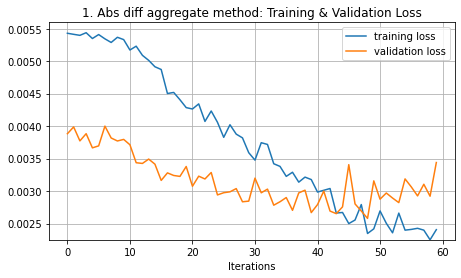

Final training accuracy: 0.869592
Final validation accuracy: 0.778571


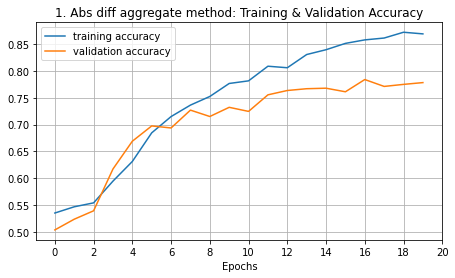

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '1. Abs diff aggregate method')

#### **[Q6]**
The optimal threshold came out to be 0.45 with the corresponding validation accuracy 0.7790.

In [ ]:
model2 = Net2().cuda()  # using the elementwise absolute difference aggregate function
n_epoch = 20
optimizer = optim.Adam(model2.parameters())  # Adam optiizer used with default setting
criterion = nn.BCELoss()  # binary cross-entropy loss function
#val_loss = load_checkpoint('model.sav', model, optimizer)
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5
training_loss, training_acc, validation_loss, validation_acc = TRAIN(model2, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005675 Accuracy 0.492969



Epoch:1 Batch:20 Loss:0.005441 Accuracy 0.508594



Epoch:1 Batch:30 Loss:0.005433 Accuracy 0.505729

optimal threshold: 0.300000 score: 0.500000
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005499 Accuracy 0.523438



Epoch:2 Batch:20 Loss:0.005467 Accuracy 0.501172



Epoch:2 Batch:30 Loss:0.005431 Accuracy 0.499479

optimal threshold: 0.550000 score: 0.510000
In Epoch 3



Epoch:3 Batch:10 Loss:0.005813 Accuracy 0.500000



Epoch:3 Batch:20 Loss:0.005435 Accuracy 0.504687



Epoch:3 Batch:30 Loss:0.005420 Accuracy 0.504427

optimal threshold: 0.550000 score: 0.505238
In Epoch 4



Epoch:4 Batch:10 Loss:0.005422 Accuracy 0.511719



Epoch:4 Batch:20 Loss:0.005406 Accuracy 0.503906



Epoch:4 Batch:30 Loss:0.005433 Accuracy 0.503906

optimal threshold: 0.550000 score: 0.502857
In Epoch 5



Epoch:5 Batch:10 Loss:0.005393 Accuracy 0.540625



Epoch:5 Batch:20 Loss:0.005407 Accuracy 0.523828



Epoch:5 Batch:30 Loss:0.005385 Accuracy 0.527344

optimal threshold: 0.450000 score: 0.515238
In Epoch 6



Epoch:6 Batch:10 Loss:0.005345 Accuracy 0.552344



Epoch:6 Batch:20 Loss:0.005361 Accuracy 0.555469



Epoch:6 Batch:30 Loss:0.005427 Accuracy 0.539323

optimal threshold: 0.550000 score: 0.521905
In Epoch 7



Epoch:7 Batch:10 Loss:0.005401 Accuracy 0.537500



Epoch:7 Batch:20 Loss:0.005363 Accuracy 0.541016



Epoch:7 Batch:30 Loss:0.005303 Accuracy 0.552604

optimal threshold: 0.500000 score: 0.554762
In Epoch 8



Epoch:8 Batch:10 Loss:0.005320 Accuracy 0.545313



Epoch:8 Batch:20 Loss:0.005336 Accuracy 0.542578



Epoch:8 Batch:30 Loss:0.005294 Accuracy 0.555208

optimal threshold: 0.450000 score: 0.539048
In Epoch 9



Epoch:9 Batch:10 Loss:0.005382 Accuracy 0.541406



Epoch:9 Batch:20 Loss:0.005330 Accuracy 0.543750



Epoch:9 Batch:30 Loss:0.005309 Accuracy 0.553906

optimal threshold: 0.500000 score: 0.570000
In Epoch 10



Epoch:10 Batch:10 Loss:0.005330 Accuracy 0.565625



Epoch:10 Batch:20 Loss:0.005267 Accuracy 0.567187



Epoch:10 Batch:30 Loss:0.005171 Accuracy 0.578125

optimal threshold: 0.500000 score: 0.571905
In Epoch 11



Epoch:11 Batch:10 Loss:0.005296 Accuracy 0.559375



Epoch:11 Batch:20 Loss:0.005304 Accuracy 0.568750



Epoch:11 Batch:30 Loss:0.005213 Accuracy 0.578385

optimal threshold: 0.500000 score: 0.575714
In Epoch 12



Epoch:12 Batch:10 Loss:0.005251 Accuracy 0.563281



Epoch:12 Batch:20 Loss:0.005283 Accuracy 0.572266



Epoch:12 Batch:30 Loss:0.005158 Accuracy 0.583073

optimal threshold: 0.500000 score: 0.548095
In Epoch 13



Epoch:13 Batch:10 Loss:0.005268 Accuracy 0.574219



Epoch:13 Batch:20 Loss:0.005288 Accuracy 0.577734



Epoch:13 Batch:30 Loss:0.005232 Accuracy 0.582031

optimal threshold: 0.500000 score: 0.561905
In Epoch 14



Epoch:14 Batch:10 Loss:0.005245 Accuracy 0.598437



Epoch:14 Batch:20 Loss:0.005246 Accuracy 0.589453



Epoch:14 Batch:30 Loss:0.005195 Accuracy 0.589063

optimal threshold: 0.500000 score: 0.581905
In Epoch 15



Epoch:15 Batch:10 Loss:0.005198 Accuracy 0.589063



Epoch:15 Batch:20 Loss:0.005130 Accuracy 0.591797



Epoch:15 Batch:30 Loss:0.005188 Accuracy 0.588021

optimal threshold: 0.500000 score: 0.594762
In Epoch 16



Epoch:16 Batch:10 Loss:0.005204 Accuracy 0.597656



Epoch:16 Batch:20 Loss:0.005181 Accuracy 0.594922



Epoch:16 Batch:30 Loss:0.004983 Accuracy 0.603385

optimal threshold: 0.500000 score: 0.621905
In Epoch 17



Epoch:17 Batch:10 Loss:0.005163 Accuracy 0.602344



Epoch:17 Batch:20 Loss:0.004882 Accuracy 0.625781



Epoch:17 Batch:30 Loss:0.004855 Accuracy 0.634896

optimal threshold: 0.500000 score: 0.634286
In Epoch 18



Epoch:18 Batch:10 Loss:0.004984 Accuracy 0.660937



Epoch:18 Batch:20 Loss:0.004750 Accuracy 0.671094



Epoch:18 Batch:30 Loss:0.004729 Accuracy 0.670313

optimal threshold: 0.500000 score: 0.679048
In Epoch 19



Epoch:19 Batch:10 Loss:0.004766 Accuracy 0.679688



Epoch:19 Batch:20 Loss:0.004461 Accuracy 0.692969



Epoch:19 Batch:30 Loss:0.004527 Accuracy 0.689844

optimal threshold: 0.500000 score: 0.689048
In Epoch 20



Epoch:20 Batch:10 Loss:0.004721 Accuracy 0.672656



Epoch:20 Batch:20 Loss:0.004424 Accuracy 0.691406



Epoch:20 Batch:30 Loss:0.004559 Accuracy 0.686719

optimal threshold: 0.500000 score: 0.699524
Finished Training


Final training loss: 0.004559
Final validation loss: 0.003079


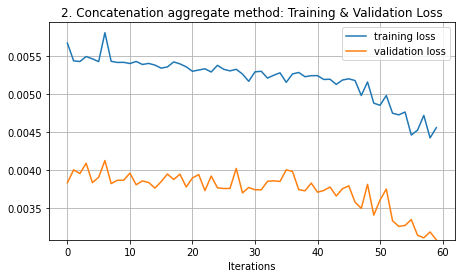

Final training accuracy: 0.687755
Final validation accuracy: 0.699524


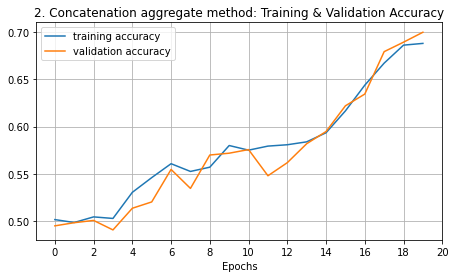

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '2. Concatenation aggregate method')

### **[Q7]** 
If the model is being implemented for similar-looking family members, an average to low threshold is sufficient. On the other hand, if its usage is face authentication for mobile banking, then a high threshold is imperative. The reason is that mobile banking must be highly private and secure so that others can't access without authorization. Therefore, if the face matching score isn't high, the high threshold will be able to deny the access.

## **4.2.5 Improving your Model**

#### **A. Optimization :**
Since the model keeps showing improvements on loss and accuracy scores over epochs, it is plausible that with more number of total epochs, or if time consuming, then increase in learning rate for faster convergence, will be able to give a better performance. 

1. Increase learning rate from 1e-3 to 5e-2

In [ ]:
model3 = Net().cuda()  
n_epoch = 20
learning_rate = 5e-2    
optimizer = optim.Adam(model3.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.BCELoss() 
#val_loss = load_checkpoint('model.sav', model, optimizer)
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN(model3, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.222505 Accuracy 0.484375



Epoch:1 Batch:20 Loss:0.171611 Accuracy 0.492969



Epoch:1 Batch:30 Loss:0.005595 Accuracy 0.502865

optimal threshold: 0.700000 score: 0.500952
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.013198 Accuracy 0.514063



Epoch:2 Batch:20 Loss:0.005488 Accuracy 0.526172



Epoch:2 Batch:30 Loss:0.005383 Accuracy 0.526823

optimal threshold: 0.450000 score: 0.560952
In Epoch 3



Epoch:3 Batch:10 Loss:0.005343 Accuracy 0.542188



Epoch:3 Batch:20 Loss:0.005356 Accuracy 0.551562



Epoch:3 Batch:30 Loss:0.005335 Accuracy 0.558594

optimal threshold: 0.550000 score: 0.582857
In Epoch 4



Epoch:4 Batch:10 Loss:0.005324 Accuracy 0.544531



Epoch:4 Batch:20 Loss:0.005352 Accuracy 0.544922



Epoch:4 Batch:30 Loss:0.005284 Accuracy 0.558594

optimal threshold: 0.550000 score: 0.577143
In Epoch 5



Epoch:5 Batch:10 Loss:0.005347 Accuracy 0.570312



Epoch:5 Batch:20 Loss:0.005291 Accuracy 0.577344



Epoch:5 Batch:30 Loss:0.005126 Accuracy 0.587500

optimal threshold: 0.500000 score: 0.615238
In Epoch 6



Epoch:6 Batch:10 Loss:0.005264 Accuracy 0.599219



Epoch:6 Batch:20 Loss:0.005128 Accuracy 0.598828



Epoch:6 Batch:30 Loss:0.005032 Accuracy 0.608073

optimal threshold: 0.500000 score: 0.602857
In Epoch 7



Epoch:7 Batch:10 Loss:0.005139 Accuracy 0.590625



Epoch:7 Batch:20 Loss:0.005018 Accuracy 0.614844



Epoch:7 Batch:30 Loss:0.005125 Accuracy 0.617708

optimal threshold: 0.500000 score: 0.613333
In Epoch 8



Epoch:8 Batch:10 Loss:0.004967 Accuracy 0.650781



Epoch:8 Batch:20 Loss:0.004986 Accuracy 0.642578



Epoch:8 Batch:30 Loss:0.004901 Accuracy 0.642708

optimal threshold: 0.550000 score: 0.647143
In Epoch 9



Epoch:9 Batch:10 Loss:0.004996 Accuracy 0.640625



Epoch:9 Batch:20 Loss:0.004976 Accuracy 0.634375



Epoch:9 Batch:30 Loss:0.004927 Accuracy 0.637240

optimal threshold: 0.550000 score: 0.629524
In Epoch 10



Epoch:10 Batch:10 Loss:0.004993 Accuracy 0.642188



Epoch:10 Batch:20 Loss:0.004839 Accuracy 0.649219



Epoch:10 Batch:30 Loss:0.004892 Accuracy 0.647396

optimal threshold: 0.550000 score: 0.646190
In Epoch 11



Epoch:11 Batch:10 Loss:0.004825 Accuracy 0.647656



Epoch:11 Batch:20 Loss:0.004935 Accuracy 0.644531



Epoch:11 Batch:30 Loss:0.004862 Accuracy 0.647135

optimal threshold: 0.600000 score: 0.627143
In Epoch 12



Epoch:12 Batch:10 Loss:0.005018 Accuracy 0.645312



Epoch:12 Batch:20 Loss:0.004764 Accuracy 0.653125



Epoch:12 Batch:30 Loss:0.004805 Accuracy 0.658073

optimal threshold: 0.500000 score: 0.643333
In Epoch 13



Epoch:13 Batch:10 Loss:0.005035 Accuracy 0.640625



Epoch:13 Batch:20 Loss:0.004791 Accuracy 0.654297



Epoch:13 Batch:30 Loss:0.004817 Accuracy 0.651823

optimal threshold: 0.500000 score: 0.659524
In Epoch 14



Epoch:14 Batch:10 Loss:0.004893 Accuracy 0.665625



Epoch:14 Batch:20 Loss:0.004784 Accuracy 0.658984



Epoch:14 Batch:30 Loss:0.004811 Accuracy 0.656771

optimal threshold: 0.400000 score: 0.655238
In Epoch 15



Epoch:15 Batch:10 Loss:0.004934 Accuracy 0.633594



Epoch:15 Batch:20 Loss:0.004691 Accuracy 0.651172



Epoch:15 Batch:30 Loss:0.004693 Accuracy 0.654167

optimal threshold: 0.500000 score: 0.656190
In Epoch 16



Epoch:16 Batch:10 Loss:0.004745 Accuracy 0.675000



Epoch:16 Batch:20 Loss:0.004668 Accuracy 0.668750



Epoch:16 Batch:30 Loss:0.004841 Accuracy 0.660156

optimal threshold: 0.550000 score: 0.659048
In Epoch 17



Epoch:17 Batch:10 Loss:0.004794 Accuracy 0.672656



Epoch:17 Batch:20 Loss:0.004595 Accuracy 0.678516



Epoch:17 Batch:30 Loss:0.004633 Accuracy 0.676042

optimal threshold: 0.450000 score: 0.670952
In Epoch 18



Epoch:18 Batch:10 Loss:0.004849 Accuracy 0.651563



Epoch:18 Batch:20 Loss:0.004455 Accuracy 0.671484



Epoch:18 Batch:30 Loss:0.004545 Accuracy 0.676042

optimal threshold: 0.500000 score: 0.674762
In Epoch 19



Epoch:19 Batch:10 Loss:0.004651 Accuracy 0.687500



Epoch:19 Batch:20 Loss:0.004377 Accuracy 0.691797



Epoch:19 Batch:30 Loss:0.004685 Accuracy 0.690625

optimal threshold: 0.450000 score: 0.683333
In Epoch 20



Epoch:20 Batch:10 Loss:0.004626 Accuracy 0.675781



Epoch:20 Batch:20 Loss:0.004368 Accuracy 0.687109



Epoch:20 Batch:30 Loss:0.004348 Accuracy 0.694792

optimal threshold: 0.600000 score: 0.698095
Finished Training


Final training loss: 0.004348
Final validation loss: 0.003602


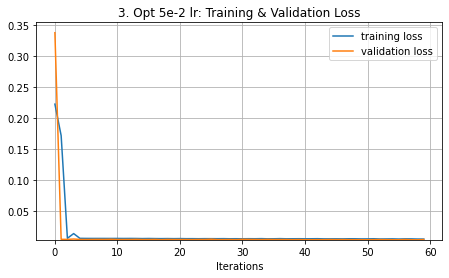

Final training accuracy: 0.696735
Final validation accuracy: 0.695714


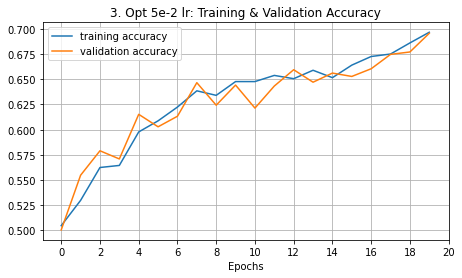

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '3. Opt 5e-2 lr' )

2. Increasing number of epochs from 20 to 30

In [ ]:
model4 = Net().cuda()  
n_epoch = 30
learning_rate = 1e-3   
optimizer = optim.Adam(model4.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.BCELoss() 
#val_loss = load_checkpoint('model.sav', model, optimizer)
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN(model4, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005448 Accuracy 0.510156



Epoch:1 Batch:20 Loss:0.005363 Accuracy 0.516797



Epoch:1 Batch:30 Loss:0.005428 Accuracy 0.518490

optimal threshold: 0.350000 score: 0.529524
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005406 Accuracy 0.524219



Epoch:2 Batch:20 Loss:0.005345 Accuracy 0.531250



Epoch:2 Batch:30 Loss:0.005369 Accuracy 0.536719

optimal threshold: 0.450000 score: 0.535714
In Epoch 3



Epoch:3 Batch:10 Loss:0.005370 Accuracy 0.555469



Epoch:3 Batch:20 Loss:0.005306 Accuracy 0.564453



Epoch:3 Batch:30 Loss:0.005215 Accuracy 0.580990

optimal threshold: 0.450000 score: 0.587143
In Epoch 4



Epoch:4 Batch:10 Loss:0.005232 Accuracy 0.610156



Epoch:4 Batch:20 Loss:0.005068 Accuracy 0.615625



Epoch:4 Batch:30 Loss:0.004938 Accuracy 0.626823

optimal threshold: 0.400000 score: 0.645714
In Epoch 5



Epoch:5 Batch:10 Loss:0.004991 Accuracy 0.627344



Epoch:5 Batch:20 Loss:0.004558 Accuracy 0.657031



Epoch:5 Batch:30 Loss:0.004413 Accuracy 0.674740

optimal threshold: 0.450000 score: 0.695238
In Epoch 6



Epoch:6 Batch:10 Loss:0.004628 Accuracy 0.675781



Epoch:6 Batch:20 Loss:0.004465 Accuracy 0.688672



Epoch:6 Batch:30 Loss:0.004478 Accuracy 0.688542

optimal threshold: 0.450000 score: 0.713810
In Epoch 7



Epoch:7 Batch:10 Loss:0.004304 Accuracy 0.724219



Epoch:7 Batch:20 Loss:0.004064 Accuracy 0.730469



Epoch:7 Batch:30 Loss:0.004060 Accuracy 0.737240

optimal threshold: 0.350000 score: 0.719524
In Epoch 8



Epoch:8 Batch:10 Loss:0.003984 Accuracy 0.751563



Epoch:8 Batch:20 Loss:0.003836 Accuracy 0.757031



Epoch:8 Batch:30 Loss:0.004010 Accuracy 0.753906

optimal threshold: 0.350000 score: 0.712381
In Epoch 9



Epoch:9 Batch:10 Loss:0.003770 Accuracy 0.768750



Epoch:9 Batch:20 Loss:0.003757 Accuracy 0.773047



Epoch:9 Batch:30 Loss:0.003660 Accuracy 0.775260

optimal threshold: 0.350000 score: 0.732381
In Epoch 10



Epoch:10 Batch:10 Loss:0.003378 Accuracy 0.808594



Epoch:10 Batch:20 Loss:0.003591 Accuracy 0.795313



Epoch:10 Batch:30 Loss:0.003647 Accuracy 0.792969

optimal threshold: 0.400000 score: 0.735238
In Epoch 11



Epoch:11 Batch:10 Loss:0.003445 Accuracy 0.806250



Epoch:11 Batch:20 Loss:0.003329 Accuracy 0.805078



Epoch:11 Batch:30 Loss:0.003320 Accuracy 0.805990

optimal threshold: 0.350000 score: 0.754286
In Epoch 12



Epoch:12 Batch:10 Loss:0.003300 Accuracy 0.813281



Epoch:12 Batch:20 Loss:0.003090 Accuracy 0.816797



Epoch:12 Batch:30 Loss:0.003206 Accuracy 0.817448

optimal threshold: 0.400000 score: 0.765238
In Epoch 13



Epoch:13 Batch:10 Loss:0.003121 Accuracy 0.807031



Epoch:13 Batch:20 Loss:0.003135 Accuracy 0.811719



Epoch:13 Batch:30 Loss:0.003054 Accuracy 0.815104

optimal threshold: 0.550000 score: 0.768571
In Epoch 14



Epoch:14 Batch:10 Loss:0.002853 Accuracy 0.845313



Epoch:14 Batch:20 Loss:0.002759 Accuracy 0.850000



Epoch:14 Batch:30 Loss:0.003037 Accuracy 0.842448

optimal threshold: 0.350000 score: 0.788095
In Epoch 15



Epoch:15 Batch:10 Loss:0.002963 Accuracy 0.830469



Epoch:15 Batch:20 Loss:0.002776 Accuracy 0.840625



Epoch:15 Batch:30 Loss:0.002944 Accuracy 0.839063

optimal threshold: 0.450000 score: 0.771905
In Epoch 16



Epoch:16 Batch:10 Loss:0.002780 Accuracy 0.841406



Epoch:16 Batch:20 Loss:0.002757 Accuracy 0.843359



Epoch:16 Batch:30 Loss:0.002590 Accuracy 0.847656

optimal threshold: 0.350000 score: 0.786190
In Epoch 17



Epoch:17 Batch:10 Loss:0.002339 Accuracy 0.884375



Epoch:17 Batch:20 Loss:0.002396 Accuracy 0.878516



Epoch:17 Batch:30 Loss:0.002462 Accuracy 0.874219

optimal threshold: 0.350000 score: 0.791429
In Epoch 18



Epoch:18 Batch:10 Loss:0.002482 Accuracy 0.856250



Epoch:18 Batch:20 Loss:0.002347 Accuracy 0.864844



Epoch:18 Batch:30 Loss:0.002522 Accuracy 0.866406

optimal threshold: 0.450000 score: 0.784762
In Epoch 19



Epoch:19 Batch:10 Loss:0.002167 Accuracy 0.882031



Epoch:19 Batch:20 Loss:0.002159 Accuracy 0.884375



Epoch:19 Batch:30 Loss:0.002379 Accuracy 0.879688

optimal threshold: 0.350000 score: 0.795238
In Epoch 20



Epoch:20 Batch:10 Loss:0.002152 Accuracy 0.886719



Epoch:20 Batch:20 Loss:0.001980 Accuracy 0.897266



Epoch:20 Batch:30 Loss:0.002343 Accuracy 0.889844

optimal threshold: 0.300000 score: 0.799048
In Epoch 21



Epoch:21 Batch:10 Loss:0.002141 Accuracy 0.889844



Epoch:21 Batch:20 Loss:0.001816 Accuracy 0.898047



Epoch:21 Batch:30 Loss:0.001912 Accuracy 0.901042

optimal threshold: 0.300000 score: 0.797619
In Epoch 22



Epoch:22 Batch:10 Loss:0.001631 Accuracy 0.922656



Epoch:22 Batch:20 Loss:0.001567 Accuracy 0.916797



Epoch:22 Batch:30 Loss:0.001749 Accuracy 0.913281

optimal threshold: 0.300000 score: 0.796190
In Epoch 23



Epoch:23 Batch:10 Loss:0.001493 Accuracy 0.919531



Epoch:23 Batch:20 Loss:0.001576 Accuracy 0.917188



Epoch:23 Batch:30 Loss:0.001742 Accuracy 0.913021

optimal threshold: 0.300000 score: 0.790476
In Epoch 24



Epoch:24 Batch:10 Loss:0.001498 Accuracy 0.921875



Epoch:24 Batch:20 Loss:0.001816 Accuracy 0.906641



Epoch:24 Batch:30 Loss:0.001699 Accuracy 0.906510

optimal threshold: 0.300000 score: 0.798095
In Epoch 25



Epoch:25 Batch:10 Loss:0.001535 Accuracy 0.917969



Epoch:25 Batch:20 Loss:0.001385 Accuracy 0.919922



Epoch:25 Batch:30 Loss:0.001546 Accuracy 0.917188

optimal threshold: 0.300000 score: 0.794762
In Epoch 26



Epoch:26 Batch:10 Loss:0.001234 Accuracy 0.947656



Epoch:26 Batch:20 Loss:0.001082 Accuracy 0.946875



Epoch:26 Batch:30 Loss:0.001119 Accuracy 0.946615

optimal threshold: 0.350000 score: 0.797619
In Epoch 27



Epoch:27 Batch:10 Loss:0.001223 Accuracy 0.932813



Epoch:27 Batch:20 Loss:0.001093 Accuracy 0.940234



Epoch:27 Batch:30 Loss:0.001127 Accuracy 0.942188

optimal threshold: 0.300000 score: 0.795714
In Epoch 28



Epoch:28 Batch:10 Loss:0.001360 Accuracy 0.919531



Epoch:28 Batch:20 Loss:0.001460 Accuracy 0.921875



Epoch:28 Batch:30 Loss:0.001479 Accuracy 0.921615

optimal threshold: 0.350000 score: 0.780952
In Epoch 29



Epoch:29 Batch:10 Loss:0.001015 Accuracy 0.945312



Epoch:29 Batch:20 Loss:0.000852 Accuracy 0.953906



Epoch:29 Batch:30 Loss:0.000779 Accuracy 0.955990

optimal threshold: 0.300000 score: 0.792381
In Epoch 30



Epoch:30 Batch:10 Loss:0.000841 Accuracy 0.965625



Epoch:30 Batch:20 Loss:0.000743 Accuracy 0.970703



Epoch:30 Batch:30 Loss:0.000697 Accuracy 0.969531

optimal threshold: 0.300000 score: 0.794286
Finished Training


Final training loss: 0.000697
Final validation loss: 0.003987


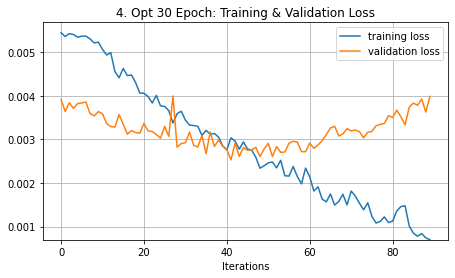

Final training accuracy: 0.965918
Final validation accuracy: 0.780000


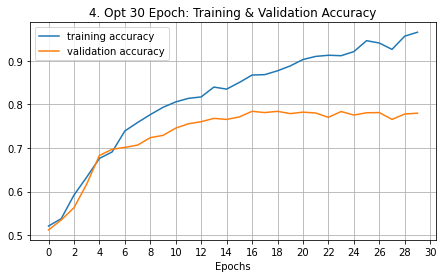

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '4. Opt 30 Epoch')

We can observe that the training loss and accuracy score both improve with respect to the increase in learning rate or total number of epochs. On the contrary, validation loss and accuracy score don't show any improvements. Moreover, the validation loss started to increase back up after 60th iteration, showing sign of overfitting. Therefore, the original number of epochs and the default learning rate performed the best. The last method will be implementing Adamax as the optimizer, which is a varient of Adam on infinity norm. 

3. Adam Optimizer to Adamax optimizer

In [ ]:
model5 = Net().cuda()  
n_epoch = 20
learning_rate = 1e-3   
optimizer = optim.Adamax(model5.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.BCELoss() 
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN(model5, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005408 Accuracy 0.517969



Epoch:1 Batch:20 Loss:0.005380 Accuracy 0.515625



Epoch:1 Batch:30 Loss:0.005352 Accuracy 0.523958

optimal threshold: 0.500000 score: 0.522381
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005426 Accuracy 0.513281



Epoch:2 Batch:20 Loss:0.005304 Accuracy 0.528906



Epoch:2 Batch:30 Loss:0.005289 Accuracy 0.536719

optimal threshold: 0.500000 score: 0.568095
In Epoch 3



Epoch:3 Batch:10 Loss:0.005251 Accuracy 0.600781



Epoch:3 Batch:20 Loss:0.005202 Accuracy 0.600391



Epoch:3 Batch:30 Loss:0.005074 Accuracy 0.608073

optimal threshold: 0.450000 score: 0.641429
In Epoch 4



Epoch:4 Batch:10 Loss:0.004842 Accuracy 0.646875



Epoch:4 Batch:20 Loss:0.004746 Accuracy 0.650000



Epoch:4 Batch:30 Loss:0.004793 Accuracy 0.654948

optimal threshold: 0.450000 score: 0.684762
In Epoch 5



Epoch:5 Batch:10 Loss:0.004568 Accuracy 0.689063



Epoch:5 Batch:20 Loss:0.004452 Accuracy 0.694922



Epoch:5 Batch:30 Loss:0.004581 Accuracy 0.689583

optimal threshold: 0.400000 score: 0.704762
In Epoch 6



Epoch:6 Batch:10 Loss:0.004318 Accuracy 0.727344



Epoch:6 Batch:20 Loss:0.004354 Accuracy 0.717188



Epoch:6 Batch:30 Loss:0.004563 Accuracy 0.706771

optimal threshold: 0.500000 score: 0.690952
In Epoch 7



Epoch:7 Batch:10 Loss:0.004290 Accuracy 0.715625



Epoch:7 Batch:20 Loss:0.004100 Accuracy 0.725000



Epoch:7 Batch:30 Loss:0.004251 Accuracy 0.722135

optimal threshold: 0.450000 score: 0.723333
In Epoch 8



Epoch:8 Batch:10 Loss:0.004122 Accuracy 0.724219



Epoch:8 Batch:20 Loss:0.003984 Accuracy 0.739844



Epoch:8 Batch:30 Loss:0.003998 Accuracy 0.742188

optimal threshold: 0.450000 score: 0.729524
In Epoch 9



Epoch:9 Batch:10 Loss:0.003867 Accuracy 0.746094



Epoch:9 Batch:20 Loss:0.003913 Accuracy 0.748047



Epoch:9 Batch:30 Loss:0.003862 Accuracy 0.753125

optimal threshold: 0.400000 score: 0.733333
In Epoch 10



Epoch:10 Batch:10 Loss:0.003780 Accuracy 0.771094



Epoch:10 Batch:20 Loss:0.003729 Accuracy 0.775781



Epoch:10 Batch:30 Loss:0.003714 Accuracy 0.776823

optimal threshold: 0.350000 score: 0.732857
In Epoch 11



Epoch:11 Batch:10 Loss:0.003516 Accuracy 0.785156



Epoch:11 Batch:20 Loss:0.003533 Accuracy 0.789453



Epoch:11 Batch:30 Loss:0.003496 Accuracy 0.787760

optimal threshold: 0.400000 score: 0.750000
In Epoch 12



Epoch:12 Batch:10 Loss:0.003334 Accuracy 0.810938



Epoch:12 Batch:20 Loss:0.003291 Accuracy 0.809375



Epoch:12 Batch:30 Loss:0.003454 Accuracy 0.802083

optimal threshold: 0.350000 score: 0.753333
In Epoch 13



Epoch:13 Batch:10 Loss:0.003000 Accuracy 0.835156



Epoch:13 Batch:20 Loss:0.003085 Accuracy 0.831641



Epoch:13 Batch:30 Loss:0.003439 Accuracy 0.821875

optimal threshold: 0.350000 score: 0.753333
In Epoch 14



Epoch:14 Batch:10 Loss:0.003099 Accuracy 0.807813



Epoch:14 Batch:20 Loss:0.002999 Accuracy 0.821875



Epoch:14 Batch:30 Loss:0.002932 Accuracy 0.826563

optimal threshold: 0.350000 score: 0.770952
In Epoch 15



Epoch:15 Batch:10 Loss:0.002821 Accuracy 0.841406



Epoch:15 Batch:20 Loss:0.002690 Accuracy 0.851562



Epoch:15 Batch:30 Loss:0.002729 Accuracy 0.851563

optimal threshold: 0.400000 score: 0.765714
In Epoch 16



Epoch:16 Batch:10 Loss:0.002589 Accuracy 0.868750



Epoch:16 Batch:20 Loss:0.002615 Accuracy 0.865625



Epoch:16 Batch:30 Loss:0.002630 Accuracy 0.861198

optimal threshold: 0.300000 score: 0.759524
In Epoch 17



Epoch:17 Batch:10 Loss:0.002621 Accuracy 0.850000



Epoch:17 Batch:20 Loss:0.002480 Accuracy 0.864453



Epoch:17 Batch:30 Loss:0.002538 Accuracy 0.860938

optimal threshold: 0.350000 score: 0.759524
In Epoch 18



Epoch:18 Batch:10 Loss:0.002411 Accuracy 0.878906



Epoch:18 Batch:20 Loss:0.002397 Accuracy 0.874219



Epoch:18 Batch:30 Loss:0.002444 Accuracy 0.869792

optimal threshold: 0.300000 score: 0.769048
In Epoch 19



Epoch:19 Batch:10 Loss:0.002199 Accuracy 0.887500



Epoch:19 Batch:20 Loss:0.002007 Accuracy 0.894922



Epoch:19 Batch:30 Loss:0.002304 Accuracy 0.891667

optimal threshold: 0.400000 score: 0.766190
In Epoch 20



Epoch:20 Batch:10 Loss:0.001929 Accuracy 0.908594



Epoch:20 Batch:20 Loss:0.002009 Accuracy 0.902734



Epoch:20 Batch:30 Loss:0.002201 Accuracy 0.897135

optimal threshold: 0.400000 score: 0.763333
Finished Training


Final training loss: 0.002201
Final validation loss: 0.003353


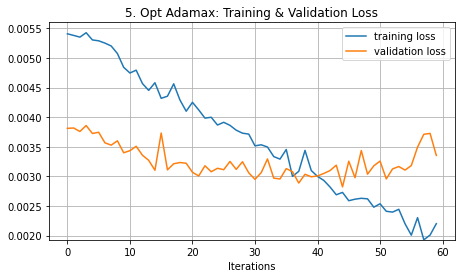

Final training accuracy: 0.894490
Final validation accuracy: 0.755238


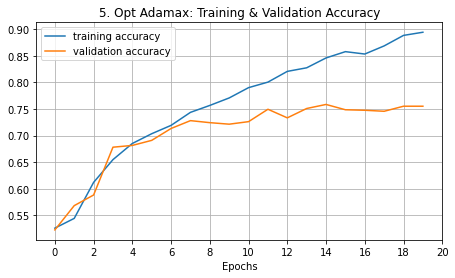

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '5. Opt Adamax')

#### **C. Data augmentation:**

Data augmentation, in this case image augmentation, is a technique of enlarging datasize by adding images that are transformed from the original images.

To augment the image data, we can either increase number of total epochs or modify the  ```__len__``` method to return the desired number of datasize. Since the images are transformed with the predefined probability in every iteration, having more epochs will be able to train the model with more augmented (i.e. transformed) image data. 


In the first implementation, <font color = blue>*random horizontal flip with probability 0.7 and normalization* </font> method is used. After analyzing the result, other renowned image augmentation methods will be determined. Epoch will be initially set to 25 for sufficient training. Modification will be made subject to the behavior of the model.

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(p = 0.7),
                            transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), 
                            transforms.Normalize((0.5, ), (0.5, ))])

train_dataset = ImageDataset(csv_file = 'train.csv', image_dir = 'index.txt', transform = trans)
valid_dataset = ImageDataset(csv_file = 'valid.csv', image_dir = 'index.txt', transform = trans)
test_dataset = ImageDataset(csv_file = 'test.csv', image_dir = 'index.txt', transform= trans)


train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)

In [ ]:
dropout_rate = 0.5
model6 = Net().cuda()  
n_epoch = 25
learning_rate = 1e-3   
optimizer = optim.Adam(model6.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.BCELoss() 
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN(model6, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005505 Accuracy 0.503906



Epoch:1 Batch:20 Loss:0.005402 Accuracy 0.514453



Epoch:1 Batch:30 Loss:0.005295 Accuracy 0.533333

optimal threshold: 0.500000 score: 0.548571
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005213 Accuracy 0.571875



Epoch:2 Batch:20 Loss:0.005145 Accuracy 0.584766



Epoch:2 Batch:30 Loss:0.005278 Accuracy 0.584896

optimal threshold: 0.500000 score: 0.562857
In Epoch 3



Epoch:3 Batch:10 Loss:0.005106 Accuracy 0.630469



Epoch:3 Batch:20 Loss:0.005098 Accuracy 0.623438



Epoch:3 Batch:30 Loss:0.004985 Accuracy 0.622135

optimal threshold: 0.450000 score: 0.639524
In Epoch 4



Epoch:4 Batch:10 Loss:0.004787 Accuracy 0.675781



Epoch:4 Batch:20 Loss:0.004660 Accuracy 0.678516



Epoch:4 Batch:30 Loss:0.004614 Accuracy 0.683594

optimal threshold: 0.350000 score: 0.690476
In Epoch 5



Epoch:5 Batch:10 Loss:0.004360 Accuracy 0.701563



Epoch:5 Batch:20 Loss:0.004493 Accuracy 0.693750



Epoch:5 Batch:30 Loss:0.004806 Accuracy 0.680990

optimal threshold: 0.300000 score: 0.698095
In Epoch 6



Epoch:6 Batch:10 Loss:0.004433 Accuracy 0.712500



Epoch:6 Batch:20 Loss:0.004190 Accuracy 0.713672



Epoch:6 Batch:30 Loss:0.004316 Accuracy 0.714844

optimal threshold: 0.350000 score: 0.714762
In Epoch 7



Epoch:7 Batch:10 Loss:0.004175 Accuracy 0.727344



Epoch:7 Batch:20 Loss:0.004002 Accuracy 0.739453



Epoch:7 Batch:30 Loss:0.004176 Accuracy 0.738021

optimal threshold: 0.400000 score: 0.734762
In Epoch 8



Epoch:8 Batch:10 Loss:0.003976 Accuracy 0.767188



Epoch:8 Batch:20 Loss:0.003814 Accuracy 0.765234



Epoch:8 Batch:30 Loss:0.003702 Accuracy 0.770313

optimal threshold: 0.350000 score: 0.747619
In Epoch 9



Epoch:9 Batch:10 Loss:0.003560 Accuracy 0.778125



Epoch:9 Batch:20 Loss:0.003616 Accuracy 0.780469



Epoch:9 Batch:30 Loss:0.003957 Accuracy 0.769271

optimal threshold: 0.300000 score: 0.756667
In Epoch 10



Epoch:10 Batch:10 Loss:0.003473 Accuracy 0.797656



Epoch:10 Batch:20 Loss:0.003556 Accuracy 0.798438



Epoch:10 Batch:30 Loss:0.003372 Accuracy 0.798698

optimal threshold: 0.400000 score: 0.749048
In Epoch 11



Epoch:11 Batch:10 Loss:0.003557 Accuracy 0.783594



Epoch:11 Batch:20 Loss:0.003454 Accuracy 0.783594



Epoch:11 Batch:30 Loss:0.003438 Accuracy 0.785938

optimal threshold: 0.400000 score: 0.755714
In Epoch 12



Epoch:12 Batch:10 Loss:0.003164 Accuracy 0.817969



Epoch:12 Batch:20 Loss:0.003075 Accuracy 0.818359



Epoch:12 Batch:30 Loss:0.003211 Accuracy 0.817448

optimal threshold: 0.450000 score: 0.774286
In Epoch 13



Epoch:13 Batch:10 Loss:0.002951 Accuracy 0.849219



Epoch:13 Batch:20 Loss:0.002855 Accuracy 0.845313



Epoch:13 Batch:30 Loss:0.003048 Accuracy 0.834896

optimal threshold: 0.500000 score: 0.790000
In Epoch 14



Epoch:14 Batch:10 Loss:0.002946 Accuracy 0.823438



Epoch:14 Batch:20 Loss:0.002854 Accuracy 0.836719



Epoch:14 Batch:30 Loss:0.002725 Accuracy 0.839063

optimal threshold: 0.450000 score: 0.785714
In Epoch 15



Epoch:15 Batch:10 Loss:0.002657 Accuracy 0.857031



Epoch:15 Batch:20 Loss:0.002555 Accuracy 0.855859



Epoch:15 Batch:30 Loss:0.002967 Accuracy 0.847917

optimal threshold: 0.450000 score: 0.791905
In Epoch 16



Epoch:16 Batch:10 Loss:0.002645 Accuracy 0.847656



Epoch:16 Batch:20 Loss:0.002570 Accuracy 0.858594



Epoch:16 Batch:30 Loss:0.002580 Accuracy 0.855990

optimal threshold: 0.300000 score: 0.806190
In Epoch 17



Epoch:17 Batch:10 Loss:0.002565 Accuracy 0.853125



Epoch:17 Batch:20 Loss:0.002201 Accuracy 0.869531



Epoch:17 Batch:30 Loss:0.002551 Accuracy 0.864583

optimal threshold: 0.500000 score: 0.797619
In Epoch 18



Epoch:18 Batch:10 Loss:0.002251 Accuracy 0.893750



Epoch:18 Batch:20 Loss:0.002283 Accuracy 0.881641



Epoch:18 Batch:30 Loss:0.002232 Accuracy 0.883854

optimal threshold: 0.450000 score: 0.805238
In Epoch 19



Epoch:19 Batch:10 Loss:0.002095 Accuracy 0.892969



Epoch:19 Batch:20 Loss:0.002160 Accuracy 0.885938



Epoch:19 Batch:30 Loss:0.002323 Accuracy 0.882292

optimal threshold: 0.550000 score: 0.805714
In Epoch 20



Epoch:20 Batch:10 Loss:0.002066 Accuracy 0.888281



Epoch:20 Batch:20 Loss:0.002042 Accuracy 0.887891



Epoch:20 Batch:30 Loss:0.002191 Accuracy 0.885938

optimal threshold: 0.450000 score: 0.806190
In Epoch 21



Epoch:21 Batch:10 Loss:0.001800 Accuracy 0.911719



Epoch:21 Batch:20 Loss:0.001779 Accuracy 0.905859



Epoch:21 Batch:30 Loss:0.002148 Accuracy 0.900260

optimal threshold: 0.400000 score: 0.811905
In Epoch 22



Epoch:22 Batch:10 Loss:0.001534 Accuracy 0.919531



Epoch:22 Batch:20 Loss:0.001713 Accuracy 0.915625



Epoch:22 Batch:30 Loss:0.001784 Accuracy 0.916146

optimal threshold: 0.450000 score: 0.815714
In Epoch 23



Epoch:23 Batch:10 Loss:0.001532 Accuracy 0.921094



Epoch:23 Batch:20 Loss:0.001619 Accuracy 0.916797



Epoch:23 Batch:30 Loss:0.001670 Accuracy 0.917188

optimal threshold: 0.500000 score: 0.803333
In Epoch 24



Epoch:24 Batch:10 Loss:0.001578 Accuracy 0.922656



Epoch:24 Batch:20 Loss:0.001468 Accuracy 0.925391



Epoch:24 Batch:30 Loss:0.001550 Accuracy 0.922917

optimal threshold: 0.350000 score: 0.797143
In Epoch 25



Epoch:25 Batch:10 Loss:0.001197 Accuracy 0.946094



Epoch:25 Batch:20 Loss:0.001258 Accuracy 0.945703



Epoch:25 Batch:30 Loss:0.001397 Accuracy 0.938542

optimal threshold: 0.300000 score: 0.809524
Finished Training


Final training loss: 0.001397
Final validation loss: 0.003198


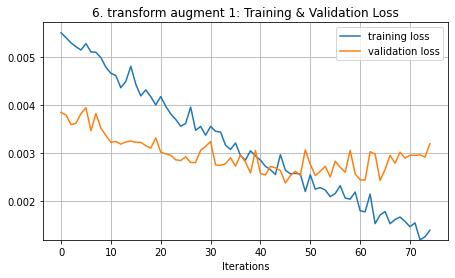

Final training accuracy: 0.933265
Final validation accuracy: 0.803810


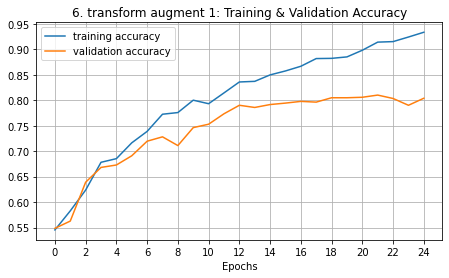

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '6. transform augment 1')

Next, we make additional modifications to the image data by using transform methods involving <font color = blue> *colorjitter and adding gaussian noise.* </font>

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(p = 0.7),
                            transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5),
                            transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), 
                            transforms.Normalize((0.5, ), (0.5, )), AddGaussianNoise(0.1, 0.08)])

train_dataset = ImageDataset(csv_file = 'train.csv', image_dir = 'index.txt', transform = trans)
valid_dataset = ImageDataset(csv_file = 'valid.csv', image_dir = 'index.txt', transform = trans)
test_dataset = ImageDataset(csv_file = 'test.csv', image_dir = 'index.txt', transform= trans)


train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)

In [ ]:
model7 = Net().cuda()  
n_epoch = 30
learning_rate = 1e-3   
optimizer = optim.Adam(model7.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.BCELoss() 
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN(model7, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)

Start Training
In Epoch 1



Epoch:1 Batch:10 Loss:0.005565 Accuracy 0.487500



Epoch:1 Batch:20 Loss:0.005432 Accuracy 0.499609



Epoch:1 Batch:30 Loss:0.005474 Accuracy 0.498958

optimal threshold: 0.300000 score: 0.500000
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2



Epoch:2 Batch:10 Loss:0.005479 Accuracy 0.515625



Epoch:2 Batch:20 Loss:0.005452 Accuracy 0.513672



Epoch:2 Batch:30 Loss:0.005448 Accuracy 0.510938

optimal threshold: 0.450000 score: 0.505238
In Epoch 3



Epoch:3 Batch:10 Loss:0.005462 Accuracy 0.499219



Epoch:3 Batch:20 Loss:0.005394 Accuracy 0.516016



Epoch:3 Batch:30 Loss:0.005435 Accuracy 0.507031

optimal threshold: 0.500000 score: 0.501905
In Epoch 4



Epoch:4 Batch:10 Loss:0.005432 Accuracy 0.487500



Epoch:4 Batch:20 Loss:0.005409 Accuracy 0.493750



Epoch:4 Batch:30 Loss:0.005476 Accuracy 0.496094

optimal threshold: 0.500000 score: 0.513333
In Epoch 5



Epoch:5 Batch:10 Loss:0.005445 Accuracy 0.508594



Epoch:5 Batch:20 Loss:0.005424 Accuracy 0.505469



Epoch:5 Batch:30 Loss:0.005454 Accuracy 0.509115

optimal threshold: 0.450000 score: 0.519048
In Epoch 6



Epoch:6 Batch:10 Loss:0.005443 Accuracy 0.501563



Epoch:6 Batch:20 Loss:0.005420 Accuracy 0.504297



Epoch:6 Batch:30 Loss:0.005415 Accuracy 0.502604

optimal threshold: 0.500000 score: 0.526190
In Epoch 7



Epoch:7 Batch:10 Loss:0.005414 Accuracy 0.535937



Epoch:7 Batch:20 Loss:0.005421 Accuracy 0.521875



Epoch:7 Batch:30 Loss:0.005415 Accuracy 0.515625

optimal threshold: 0.500000 score: 0.526667
In Epoch 8



Epoch:8 Batch:10 Loss:0.005422 Accuracy 0.511719



Epoch:8 Batch:20 Loss:0.005407 Accuracy 0.508984



Epoch:8 Batch:30 Loss:0.005418 Accuracy 0.511198

optimal threshold: 0.500000 score: 0.510476
In Epoch 9



Epoch:9 Batch:10 Loss:0.005420 Accuracy 0.503125



Epoch:9 Batch:20 Loss:0.005398 Accuracy 0.520703



Epoch:9 Batch:30 Loss:0.005413 Accuracy 0.510156

optimal threshold: 0.500000 score: 0.507619
In Epoch 10



Epoch:10 Batch:10 Loss:0.005394 Accuracy 0.534375



Epoch:10 Batch:20 Loss:0.005403 Accuracy 0.525391



Epoch:10 Batch:30 Loss:0.005405 Accuracy 0.519792

optimal threshold: 0.500000 score: 0.523333
In Epoch 11



Epoch:11 Batch:10 Loss:0.005361 Accuracy 0.550781



Epoch:11 Batch:20 Loss:0.005392 Accuracy 0.536719



Epoch:11 Batch:30 Loss:0.005340 Accuracy 0.540625

optimal threshold: 0.450000 score: 0.544286
In Epoch 12



Epoch:12 Batch:10 Loss:0.005333 Accuracy 0.542969



Epoch:12 Batch:20 Loss:0.005251 Accuracy 0.565234



Epoch:12 Batch:30 Loss:0.005283 Accuracy 0.570573

optimal threshold: 0.450000 score: 0.594286
In Epoch 13



Epoch:13 Batch:10 Loss:0.005206 Accuracy 0.606250



Epoch:13 Batch:20 Loss:0.005081 Accuracy 0.618359



Epoch:13 Batch:30 Loss:0.005243 Accuracy 0.606510

optimal threshold: 0.450000 score: 0.622857
In Epoch 14



Epoch:14 Batch:10 Loss:0.005265 Accuracy 0.575000



Epoch:14 Batch:20 Loss:0.005119 Accuracy 0.592969



Epoch:14 Batch:30 Loss:0.005081 Accuracy 0.601563

optimal threshold: 0.500000 score: 0.618095
In Epoch 15



Epoch:15 Batch:10 Loss:0.004999 Accuracy 0.619531



Epoch:15 Batch:20 Loss:0.004759 Accuracy 0.639063



Epoch:15 Batch:30 Loss:0.004764 Accuracy 0.647135

optimal threshold: 0.400000 score: 0.682857
In Epoch 16



Epoch:16 Batch:10 Loss:0.004664 Accuracy 0.660937



Epoch:16 Batch:20 Loss:0.004867 Accuracy 0.657813



Epoch:16 Batch:30 Loss:0.004699 Accuracy 0.663542

optimal threshold: 0.500000 score: 0.679048
In Epoch 17



Epoch:17 Batch:10 Loss:0.004527 Accuracy 0.693750



Epoch:17 Batch:20 Loss:0.004575 Accuracy 0.692187



Epoch:17 Batch:30 Loss:0.004428 Accuracy 0.690885

optimal threshold: 0.350000 score: 0.697619
In Epoch 18



Epoch:18 Batch:10 Loss:0.004604 Accuracy 0.676562



Epoch:18 Batch:20 Loss:0.004316 Accuracy 0.695703



Epoch:18 Batch:30 Loss:0.004417 Accuracy 0.696354

optimal threshold: 0.300000 score: 0.702381
In Epoch 19



Epoch:19 Batch:10 Loss:0.004279 Accuracy 0.684375



Epoch:19 Batch:20 Loss:0.004467 Accuracy 0.681641



Epoch:19 Batch:30 Loss:0.004305 Accuracy 0.695052

optimal threshold: 0.350000 score: 0.704286
In Epoch 20



Epoch:20 Batch:10 Loss:0.004251 Accuracy 0.717969



Epoch:20 Batch:20 Loss:0.004334 Accuracy 0.714453



Epoch:20 Batch:30 Loss:0.004185 Accuracy 0.721615

optimal threshold: 0.350000 score: 0.715238
In Epoch 21



Epoch:21 Batch:10 Loss:0.004211 Accuracy 0.721094



Epoch:21 Batch:20 Loss:0.004013 Accuracy 0.734375



Epoch:21 Batch:30 Loss:0.004142 Accuracy 0.733073

optimal threshold: 0.350000 score: 0.715714
In Epoch 22



Epoch:22 Batch:10 Loss:0.004124 Accuracy 0.732031



Epoch:22 Batch:20 Loss:0.004040 Accuracy 0.726562



Epoch:22 Batch:30 Loss:0.003983 Accuracy 0.735938

optimal threshold: 0.350000 score: 0.722381
In Epoch 23



Epoch:23 Batch:10 Loss:0.004157 Accuracy 0.735938



Epoch:23 Batch:20 Loss:0.004097 Accuracy 0.738281



Epoch:23 Batch:30 Loss:0.003895 Accuracy 0.740885

optimal threshold: 0.500000 score: 0.724762
In Epoch 24



Epoch:24 Batch:10 Loss:0.003994 Accuracy 0.740625



Epoch:24 Batch:20 Loss:0.003646 Accuracy 0.755078



Epoch:24 Batch:30 Loss:0.004072 Accuracy 0.751042

optimal threshold: 0.400000 score: 0.730000
In Epoch 25



Epoch:25 Batch:10 Loss:0.003859 Accuracy 0.757031



Epoch:25 Batch:20 Loss:0.004018 Accuracy 0.753906



Epoch:25 Batch:30 Loss:0.003810 Accuracy 0.752604

optimal threshold: 0.300000 score: 0.721429
In Epoch 26



Epoch:26 Batch:10 Loss:0.003889 Accuracy 0.768750



Epoch:26 Batch:20 Loss:0.003732 Accuracy 0.775000



Epoch:26 Batch:30 Loss:0.003882 Accuracy 0.768229

optimal threshold: 0.300000 score: 0.734762
In Epoch 27



Epoch:27 Batch:10 Loss:0.003623 Accuracy 0.792188



Epoch:27 Batch:20 Loss:0.003546 Accuracy 0.790234



Epoch:27 Batch:30 Loss:0.003877 Accuracy 0.779948

optimal threshold: 0.400000 score: 0.745714
In Epoch 28



Epoch:28 Batch:10 Loss:0.004060 Accuracy 0.746875



Epoch:28 Batch:20 Loss:0.003815 Accuracy 0.757422



Epoch:28 Batch:30 Loss:0.003723 Accuracy 0.761719

optimal threshold: 0.400000 score: 0.734286
In Epoch 29



Epoch:29 Batch:10 Loss:0.003824 Accuracy 0.759375



Epoch:29 Batch:20 Loss:0.003568 Accuracy 0.775781



Epoch:29 Batch:30 Loss:0.003729 Accuracy 0.773958

optimal threshold: 0.450000 score: 0.736190
In Epoch 30



Epoch:30 Batch:10 Loss:0.003671 Accuracy 0.782813



Epoch:30 Batch:20 Loss:0.003473 Accuracy 0.787891



Epoch:30 Batch:30 Loss:0.003725 Accuracy 0.780208

optimal threshold: 0.350000 score: 0.744762
Finished Training


Final training loss: 0.003725
Final validation loss: 0.002839


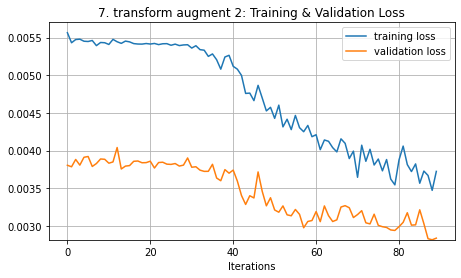

Final training accuracy: 0.777347
Final validation accuracy: 0.738095


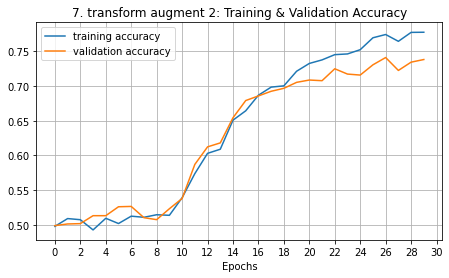

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '7. transform augment 2')

#### **E. Contrastive loss: Use CosineEmbeddingLoss**
<font color = red> Do not run. Not successful </font>

CosineEmbeddingLoss evaluates the loss of the model with two image tensors and the correct label as input. The main objective of the CosineEmbeddingLoss function is to measure whether the model is capable of differentiating the two input images and decide whether the two are similar or not. It is a very suitable loss function for a face comparison model.
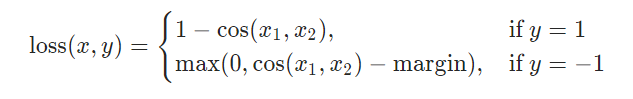

Note that the label needs to be modified to 2 * label - 1 for the label to be either 1 or -1.

In [ ]:
class Net_cosine_embedding(nn.Module):
    def __init__(self):
        super(Net_cosine_embedding, self).__init__()

        #input (32 x 32 x 1) -> conv ->  (32 x 32 x 32) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # (32 x 32 x 32) -> conv -> (32 x 32 x 32) -> max_pool -> (16 x 16 x 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)  # maxpool2d layer added
        )
        # (16 x 16 x 32) -> conv -> (16 x 16 x 64)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #(16 x 16 x 64) -> conv -> (16 x 16 x 128)
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #(16 x 16 x 128) -> conv -> (16 x 16 x 256)
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #(16 x 16 x 258) -> conv -> (16 x 16 x 512) -> avg_pool -> (1 x 512)
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 16, stride = None) # avgpool2d layer added
        )
        self.conv = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6)
        self.fc1 = nn.Linear(1 * 512, 512)
        self.drop = nn.Dropout(p = dropout_rate)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def aggregate(self, x1, x2):
        return torch.abs(x1 - x2)

    def forward(self, x1 , x2):
        x1 = self.conv(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.fc1(x1)
        
        x2 = self.conv(x2)
        x2 = x1.view(x2.size(0), -1)
        x2 = self.fc1(x2)
        output = F.cosine_similarity(x1, x2)
        output = self.sigmoid(output)

        return x1, x2, output        
       

In [ ]:
def TRAIN_cosine_embedding(model, train_loader, valid_loader, n_epochs, criterion, optimizer, val_loss, device, pre_thresh = 0.5 , save_name = 'model.sav'):

    if val_loss == None:
        best_val_loss = float("Inf")
    else:
        best_val_loss = val_loss

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    print("Start Training")
    for epoch in range(n_epoch):
        print("In Epoch", epoch + 1)
        model.train()
        avg_loss = 0 
        val_avg_loss = 0 
        steps = 0
        num_correct = 0
        total_num = 0
        val_pred = []
        val_label = []

        
        for data in tqdm(train_loader):
            img1, img2, label = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.squeeze().to(device)
            # print(img1.shape)
            # print(img2.shape)
            # print(label.shape)
            # print((2*label - 1).shape)

            # Forward pass
            img1_out, img2_out, similarity_score = model(img1, img2)
            loss  = criterion(img1_out, img2_out, 2 * label -1)
            # print(img1_out.shape)
            # print(img2_out.shape)
            # print(label.shape)
            # print((2*label - 1))

            print("loss:", loss)

            # you are required to record the training and validation losses after every 10 steps (one step means one gradient update)
            avg_loss += loss / (len(label) * 10)   # avg_loss updated every 10 steps with batch_size, not every epoch
            
            # for training set accuracy calculation - not really necessary in pa2
            #print(similarity_score)

            similarity_score = similarity_score >= torch.FloatTensor([pre_thresh]).to(device)

            #print(similarity_score)
            #print(label.data)
            #print(similarity_score.size())
            #print(label.size())

            correct_prediction = (similarity_score == label.data)

            #print(correct_prediction.size())
            #print(torch.sum(correct_prediction))

            num_correct += torch.sum(correct_prediction)

            #print(num_correct) 
            total_num += correct_prediction.shape[0]
            #print(total_num)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps += 1
            if steps % 10 == 0:
                train_loss.append(avg_loss.item())
          
                with torch.no_grad():
                    model.eval()
                    
                    for data in tqdm(valid_loader):
                        img1, img2, label = data
                        img1 = img1.to(device)
                        img2 = img2.to(device)
                        val_label.append(label)
                        label = label.unsqueeze(1).to(device)
                        
                        img1_out, img2_out, val_similarity_score = model(img1, img2)
                        val_pred.append(val_similarity_score)
                        val_losses = criterion(img1_out, img2_out, 2*label -1)
                        val_avg_loss += val_losses / (128 *10)
                        
                    val_loss.append(val_avg_loss.cpu().detach().numpy())
                    accuracy = num_correct / total_num
                print("Epoch:{} Batch:{} Loss:{:4f} Accuracy {:3f}" .format(epoch + 1, steps, avg_loss, accuracy))
                avg_loss = 0
                val_avg_loss = 0

        # calculate training accuracy
        accuracy = num_correct / total_num
        train_acc.append(accuracy.item())

        pre_thresh_accuracy, opt_accuracy, opt_threshold = optimal_Threshold(val_pred, val_label, pre_thresh)
        val_acc.append(pre_thresh_accuracy)        
        print('optimal threshold: {:1f} score: {:3f}'.format(opt_threshold, opt_accuracy))

        if val_avg_loss < best_val_loss :  # loss니깐 적을수록 좋은거지
            best_val_loss = val_avg_loss 
            save_checkpoint(save_name, model, optimizer, best_val_loss)
      
    print("Finished Training")
    return train_loss, train_acc, val_loss, val_acc

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), 
                            transforms.Grayscale(num_output_channels=1)])

train_dataset = ImageDataset(csv_file = 'train.csv', image_dir = 'index.txt', transform = trans)
valid_dataset = ImageDataset(csv_file = 'valid.csv', image_dir = 'index.txt', transform = trans)
test_dataset = ImageDataset(csv_file = 'test.csv', image_dir = 'index.txt', transform= trans)


train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)

In [ ]:
model8 = Net_cosine_embedding().cuda()  
n_epoch = 20
learning_rate = 1e-3   
optimizer = optim.Adam(model8.parameters(), lr = learning_rate)  # Adam optiizer default learning_rate = 1e-3
criterion = nn.CosineEmbeddingLoss(margin=0.5) # cosine_embedding_loss 
val_loss= None
save_name = 'model.sav'
pre_thresh = 0.5

training_loss, training_acc, validation_loss, validation_acc = TRAIN_cosine_embedding(model8, train_loader, valid_loader, n_epoch, criterion, optimizer, val_loss, device, pre_thresh, save_name)


Start Training
In Epoch 1


loss: tensor(0.4452, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2677, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2724, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2448, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2250, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:1 Batch:10 Loss:0.002100 Accuracy 0.513281
loss: tensor(0.2589, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2662, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2616, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2406, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2652, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2229, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2585, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2366, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:1 Batch:20 Loss:0.001962 Accuracy 0.510938
loss: tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2423, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2368, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2692, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2726, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2840, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:1 Batch:30 Loss:0.002000 Accuracy 0.501823
loss: tensor(0.2607, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2422, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2601, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2644, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2365, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
Model saved to /content/drive/MyDrive/Colab Notebooks/pa2/model.sav
In Epoch 2


loss: tensor(0.2716, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2271, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2554, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2043, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2266, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2571, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2449, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2210, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:2 Batch:10 Loss:0.001889 Accuracy 0.519531
loss: tensor(0.2539, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2442, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2528, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2670, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2583, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2311, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2367, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:2 Batch:20 Loss:0.001974 Accuracy 0.506641
loss: tensor(0.2715, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2318, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2790, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2626, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2523, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2345, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2442, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:2 Batch:30 Loss:0.001982 Accuracy 0.501042
loss: tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2482, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2365, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2525, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2790, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2848, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 3


loss: tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2306, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2523, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2508, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2338, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2181, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2423, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:3 Batch:10 Loss:0.001904 Accuracy 0.513281
loss: tensor(0.2435, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2684, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2702, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2452, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2477, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2523, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2297, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2454, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:3 Batch:20 Loss:0.001960 Accuracy 0.505859
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2664, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2248, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2402, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2580, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2580, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:3 Batch:30 Loss:0.001960 Accuracy 0.503385
loss: tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2448, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2551, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2650, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2338, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 4


loss: tensor(0.2753, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2020, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2398, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2625, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2487, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2492, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2561, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2877, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:4 Batch:10 Loss:0.001963 Accuracy 0.496875
loss: tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2527, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2525, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2436, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2600, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2651, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:4 Batch:20 Loss:0.001981 Accuracy 0.489063
loss: tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2565, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2533, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2603, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2603, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2433, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:4 Batch:30 Loss:0.001977 Accuracy 0.490104
loss: tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2318, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2400, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2456, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2617, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2526, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1935, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 5


loss: tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2510, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2406, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2334, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2762, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2575, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2530, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2102, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2238, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2564, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:5 Batch:10 Loss:0.001920 Accuracy 0.508594
loss: tensor(0.2445, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2526, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2566, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2547, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2582, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2645, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2395, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:5 Batch:20 Loss:0.001944 Accuracy 0.505469
loss: tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2647, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2609, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2502, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2712, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2746, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2332, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2748, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:5 Batch:30 Loss:0.002025 Accuracy 0.496875
loss: tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2520, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2276, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2470, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2344, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2764, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 6


loss: tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2778, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2535, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2418, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:6 Batch:10 Loss:0.001960 Accuracy 0.497656
loss: tensor(0.2353, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2756, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2209, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2244, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2649, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:6 Batch:20 Loss:0.001951 Accuracy 0.499219
loss: tensor(0.2797, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2280, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2316, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2721, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2684, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2755, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:6 Batch:30 Loss:0.002008 Accuracy 0.494531
loss: tensor(0.2572, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2113, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2147, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2609, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2463, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 7


loss: tensor(0.2474, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2249, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2636, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2614, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2258, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2862, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2266, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2701, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:7 Batch:10 Loss:0.001963 Accuracy 0.496094
loss: tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2584, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2613, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2424, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3028, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2725, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:7 Batch:20 Loss:0.002007 Accuracy 0.491016
loss: tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2796, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2131, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2279, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2463, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2352, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2686, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2203, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:7 Batch:30 Loss:0.001924 Accuracy 0.496615
loss: tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2277, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2277, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2722, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2315, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2425, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2366, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 8


loss: tensor(0.2194, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2575, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2571, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2424, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2529, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2667, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:8 Batch:10 Loss:0.001952 Accuracy 0.498437
loss: tensor(0.2329, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2154, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2234, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2383, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2158, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2155, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2269, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:8 Batch:20 Loss:0.001823 Accuracy 0.516406
loss: tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2847, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3077, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2964, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2551, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2380, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2577, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2528, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:8 Batch:30 Loss:0.002061 Accuracy 0.501563
loss: tensor(0.2462, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2347, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2776, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2396, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2796, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2225, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2614, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2488, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 9


loss: tensor(0.2701, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2268, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2445, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2270, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2193, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2413, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2401, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2342, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2551, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:9 Batch:10 Loss:0.001850 Accuracy 0.525000
loss: tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2836, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2537, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2681, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2563, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:9 Batch:20 Loss:0.001999 Accuracy 0.502344
loss: tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2492, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2401, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2572, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2684, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2578, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2544, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:9 Batch:30 Loss:0.001969 Accuracy 0.499479
loss: tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2542, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2511, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2506, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.700000 score: 0.504286
In Epoch 10


loss: tensor(0.2361, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2746, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2538, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2624, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2533, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:10 Batch:10 Loss:0.001939 Accuracy 0.502344
loss: tensor(0.2516, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2466, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2611, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:10 Batch:20 Loss:0.001948 Accuracy 0.500000
loss: tensor(0.2440, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2436, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2677, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2349, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2373, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2585, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2138, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2340, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2493, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2603, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:10 Batch:30 Loss:0.001909 Accuracy 0.503906
loss: tensor(0.2246, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2488, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2918, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2356, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2487, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2917, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3158, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 11


loss: tensor(0.2868, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2301, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2717, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2133, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2470, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2489, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2407, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:11 Batch:10 Loss:0.001945 Accuracy 0.496875
loss: tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2361, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2370, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2452, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2223, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:11 Batch:20 Loss:0.001878 Accuracy 0.485156
loss: tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2480, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2594, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2505, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2523, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2509, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2479, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:11 Batch:30 Loss:0.001981 Accuracy 0.494271
loss: tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2502, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2567, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2345, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2663, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2249, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2114, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.700000 score: 0.500952
In Epoch 12


loss: tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2224, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1849, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2336, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2553, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2458, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2443, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:12 Batch:10 Loss:0.001865 Accuracy 0.524219
loss: tensor(0.2427, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2550, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2793, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2836, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2183, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2457, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2722, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:12 Batch:20 Loss:0.001969 Accuracy 0.509766
loss: tensor(0.2831, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2542, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2021, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2508, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2545, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2723, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2573, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2394, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:12 Batch:30 Loss:0.001987 Accuracy 0.503646
loss: tensor(0.2719, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2322, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2130, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2647, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2799, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2798, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2607, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 13


loss: tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2841, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2594, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2414, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2971, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2798, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2617, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2356, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:13 Batch:10 Loss:0.002026 Accuracy 0.478125
loss: tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2319, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2423, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2413, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2550, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2217, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2784, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2527, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:13 Batch:20 Loss:0.001939 Accuracy 0.490234
loss: tensor(0.2277, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2650, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2179, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2635, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2143, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2449, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2445, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:13 Batch:30 Loss:0.001895 Accuracy 0.498698
loss: tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2452, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2605, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2005, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2550, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2773, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2377, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3067, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 14


loss: tensor(0.2218, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2252, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2195, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2669, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2331, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2451, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2279, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2590, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2487, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:14 Batch:10 Loss:0.001875 Accuracy 0.520312
loss: tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2293, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2395, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2345, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2746, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2433, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2348, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:14 Batch:20 Loss:0.001910 Accuracy 0.516016
loss: tensor(0.2659, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2352, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2808, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2552, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2894, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2323, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:14 Batch:30 Loss:0.002002 Accuracy 0.505990
loss: tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2568, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2793, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2352, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2966, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1821, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 15


loss: tensor(0.2304, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2579, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2254, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2733, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2691, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:15 Batch:10 Loss:0.002005 Accuracy 0.482031
loss: tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2443, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2384, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2237, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2694, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2925, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2294, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2708, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:15 Batch:20 Loss:0.001953 Accuracy 0.490625
loss: tensor(0.2333, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2823, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2160, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2245, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2505, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1981, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:15 Batch:30 Loss:0.001855 Accuracy 0.502344
loss: tensor(0.2549, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2599, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2728, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2556, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2644, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2394, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2684, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2291, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1954, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 16


loss: tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2467, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2269, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2704, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3104, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:16 Batch:10 Loss:0.001950 Accuracy 0.498437
loss: tensor(0.2847, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2463, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2399, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2646, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2655, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2337, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2457, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2376, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2347, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:16 Batch:20 Loss:0.001918 Accuracy 0.501563
loss: tensor(0.2564, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2339, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.1939, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2751, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2736, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2429, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2726, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2600, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2681, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2557, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:16 Batch:30 Loss:0.001978 Accuracy 0.498177
loss: tensor(0.2248, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2458, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2316, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2722, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2428, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2794, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2542, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2813, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 17


loss: tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2370, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2448, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2625, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2492, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2667, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2220, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:17 Batch:10 Loss:0.001919 Accuracy 0.495313
loss: tensor(0.2505, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2442, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2427, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2639, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2511, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2511, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2470, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:17 Batch:20 Loss:0.001968 Accuracy 0.501563
loss: tensor(0.2746, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2504, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2397, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2482, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2317, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2505, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2388, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:17 Batch:30 Loss:0.001948 Accuracy 0.503906
loss: tensor(0.2680, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2504, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2593, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2590, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2457, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2366, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2322, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.700000 score: 0.503810
In Epoch 18


loss: tensor(0.2666, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2433, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2519, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2593, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2062, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2266, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:18 Batch:10 Loss:0.001940 Accuracy 0.492188
loss: tensor(0.2503, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2474, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2629, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2266, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2624, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2365, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:18 Batch:20 Loss:0.001941 Accuracy 0.497266
loss: tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2600, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2381, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2503, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2129, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2383, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2922, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2341, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:18 Batch:30 Loss:0.001926 Accuracy 0.498698
loss: tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2507, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2409, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2298, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2671, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.300000 score: 0.500000
In Epoch 19


loss: tensor(0.2373, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2585, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2516, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2579, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2460, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2587, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2432, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2386, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:19 Batch:10 Loss:0.001944 Accuracy 0.496875
loss: tensor(0.2327, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2611, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2097, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.3040, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2489, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2568, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2682, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:19 Batch:20 Loss:0.001955 Accuracy 0.493359
loss: tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2443, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2575, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2563, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2340, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:19 Batch:30 Loss:0.001951 Accuracy 0.498177
loss: tensor(0.2526, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2449, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2273, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2405, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2560, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2633, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.650000 score: 0.501905
In Epoch 20


loss: tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2737, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2139, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2678, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2171, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2335, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:20 Batch:10 Loss:0.001883 Accuracy 0.507812
loss: tensor(0.2661, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2846, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2567, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2306, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2710, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2653, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2646, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2509, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2443, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2310, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:20 Batch:20 Loss:0.002004 Accuracy 0.492188
loss: tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2466, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2415, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2422, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2557, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward0>)



Epoch:20 Batch:30 Loss:0.001937 Accuracy 0.499479
loss: tensor(0.2446, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2242, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2531, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2441, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2434, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2684, device='cuda:0', grad_fn=<MeanBackward0>)
loss: tensor(0.2884, device='cuda:0', grad_fn=<MeanBackward0>)

optimal threshold: 0.700000 score: 0.502857
Finished Training


Final training loss: 0.001937
Final validation loss: 0.001253


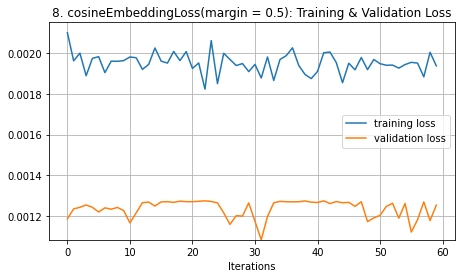

Final training accuracy: 0.500000
Final validation accuracy: 0.500000


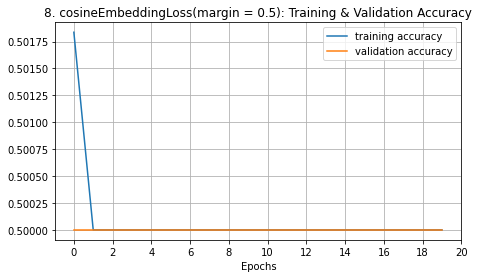

In [ ]:
plot_compare(training_loss, training_acc, validation_loss, validation_acc, '8. cosineEmbeddingLoss(margin = 0.5)')

### **[Q8]**

Before moving to the final prediction step, we compare model accuracy scores for various models implemented and choose the best one. 

(0.0, 1.0, 0.0, 1.0)

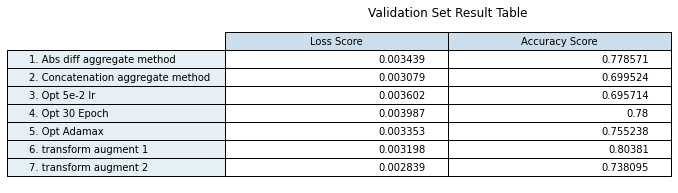

In [ ]:
result = np.array([0.003439, 0.778571, 0.003079, 0.699524, 0.003602, 0.695714,
                    0.003987, 0.7800, 0.003353, 0.755238, 0.003198, 0.803810 , 
                   0.002839, 0.738095])

result = pd.DataFrame(result.reshape(7, 2))
result.columns = ['Loss Score', 'Accuracy Score']
result.index = ['1. Abs diff aggregate method',
                '2. Concatenation aggregate method',
                '3. Opt 5e-2 lr',
                '4. Opt 30 Epoch',
                '5. Opt Adamax',
                '6. transform augment 1',
                '7. transform augment 2']
                
fig = plt.figure(figsize = (8,3))
ax = plt.subplot()
table = ax.table(cellText = result.values,
                 rowLabels = result.index,
                 rowColours = plt.cm.BuPu(np.full(len(result.index),0.1)),
                 colLabels = result.columns, 
                 colColours = plt.cm.BuPu(np.full(len(result.columns),0.2)),
                 loc = 'center')

ax.set_title("Validation Set Result Table")
table.scale(1, 1.5)
ax.axis("off")

Model 6. transform augment 1 has gave out the highest accuracy score (0.80381) among all the models. As mentioned above, through image augmentation, images are transformed from the original images and thus, enlarges datasize. With increase in total number of epochs, the bigger image dataset will be fed to the model and thus result in a higher validation accuracy. Other models failed to show a noticeable difference in the validation accuracy score compared to the first model implemented.



## **4.2.6 Prediction**

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(p = 0.7),
                            transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), 
                            transforms.Normalize((0.5, ), (0.5, ))])

train_dataset = ImageDataset(csv_file = 'train.csv', image_dir = 'index.txt', transform = trans)
valid_dataset = ImageDataset(csv_file = 'valid.csv', image_dir = 'index.txt', transform = trans)
test_dataset = ImageDataset(csv_file = 'test.csv', image_dir = 'index.txt', transform= trans)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers = 2, pin_memory= True)

### **[P1]**  p1.csv

In [ ]:
with torch.no_grad():
    model.eval()

    prediction_list = []
    for img1, img2, label in tqdm(test_loader):

        img1 = img1.to(device)
        img2 = img2.to(device)
        prediction = model(img1, img2)
        prediction = prediction >= torch.FloatTensor([pre_thresh]).to(device)
        prediction = prediction.gt(0).to(torch.int)
        prediction = torch.squeeze(prediction).cpu().detach().numpy()
        for index in range(len(prediction)):
            prediction_list.append(prediction[index])

    print(prediction_list)


[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,

In [ ]:
A = pd.read_csv(os.path.join(PATH, 'test.csv'))
B = pd.read_csv(os.path.join(PATH, 'index.txt'), header = None, delim_whitespace= True, dtype = "string")
p1 = A.copy()
p1['target'] = prediction_list
p1.head()
p1.to_csv("p1.csv")

id1   id2  target
0  4988  4973       0
1  4958  4939       0
2  4552  4891       0
3  4509  4504       1
4  4589  4587       1